In [ ]:
user = "Lena"
#user = "Varya"
#user = 'Masha'
#user = 'other'

# Комменты по работе



**!!! ВАЖНО  !!!**

Данный код работает на уже созданных датасетах после выгрузки из OSM, Trip Adviser'a и тд. Все обработки до этого моментам (например, выгрузка из OSM) - в окнце блокнота

## Основные созданные объекты

**yandex** - датасет с отзывами Yandex по Москве, адресом, названием рейтингом, данными по широте и лолготе, кухне и ценовому сегменту

**yandex_for_geo** - датасет, в котором оставили только самые важные данным для гео анализа: 'address', 'name', 'latitude', 'longitude', 'price_segment', а так же все типы cuisine и type в булевом формате

**yandex_gdf** - датасет для гео анализа, в котором к yandex_for_geo переменным добавили geometry (в формате point)

**gdf_moscow** - данные о полигоне Москвы в формате GeoDataFrame

**moscow_hex** - гексагоны Москвы в формате полигонов в GeoDataFrame

**OSM_data** - данные, скачанные с OpenStreetMap и сохраненные в один документ. Колонки element_type,	osmid	nodes,	key,	geometry,	name,	OSM_group.

**data_rayons** - данные по районам Москвы с гос источников




```
#если надо выгрузить экселевским файлом
#dataset.to_excel('file_name.xlsx', index=False)
```



```
#если надо увеличить количество отображаемых строк
#pd.set_option('display.max_rows', 112)
```







# Импорт библиотек

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import csv
import re
import io
#!pip3 install folium
import folium
from folium import Map, Choropleth, Marker
from folium.plugins import MarkerCluster
import json
from folium.plugins import HeatMap
from branca.colormap import linear
import geopandas as gpd
from geopandas.tools import geocode
!pip install geopy
from geopy.geocoders import Nominatim


!pip3 install h3
!pip3 install osmnx
import h3
import osmnx as ox
from shapely import wkt
from shapely.geometry import Polygon

!pip3 install h3pandas
import h3pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h3pandas: filename=h3pandas-0.2.6-py3-none-any.whl size=19689 sha256=cd193ce3cf56abe72f692a4acac4f3980ff4479fbc24b7fd9c08f2e80ba4c6e6
  Stored in directory: /root/.cache/pip/wheels/53/16/29/87a50ed96709a186f34192adccb57d691f2c5b6605bae71a3b
Successfully built h3pandas


# Загрузка данных

## Импорт Yandex датасета

In [ ]:
if user == "Lena":
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if user == "Lena":
  yandex = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/yandex_prefinal_for_geo.xlsx')
else:
  yandex = pd.read_excel('yandex_prefinal_for_geo.xlsx')

In [ ]:
for j in range(0, len(yandex)):
  if (yandex.iloc[j, yandex.columns.get_loc('Японская')] == 1):
    yandex.iloc[j, yandex.columns.get_loc('Азиатская')] = 1

In [ ]:
yandex = yandex.drop(columns = ['Японская'])

In [ ]:
cuisine_names = ['Европейская', 'Американская', 'Азиатская', 'Итальянская', 'Международная', 'СССР', 'Латино-американская', 'Восточная',
 'Грузинская', 'Здоровая', 'Кавказская', 'Африканская', 'Австралийская', 'Канадская', 'Новозеландская', 'Китайская', 'Шавермочная', 'Кальяночная']

type_names = ['Гриль и шашлык', 'Ресторан', 'Фастфуд', 'Кафе', 'Бар, паб, пиво, вино', 'Кофе и чай', 'Пицца', 'Суши', 'Пекарня', 'Десерты', 'Столовая',
 'Другое', 'Бургеры', 'Магазин']

features_for_geo = ['address', 'name', 'latitude', 'longitude', 'price_segment']

In [ ]:
#yandex[cuisine_names].sum(axis = 1)[(yandex[cuisine_names].sum(axis = 1) > 2)]

In [ ]:
# преобразование Яндекс датасета в гео и сохранение только ключевых колонок для гео анализа

yandex_for_geo = yandex[features_for_geo + cuisine_names + type_names]
yandex_for_geo = yandex_for_geo.drop_duplicates()
yandex_gdf = gpd.GeoDataFrame(yandex_for_geo, geometry=gpd.points_from_xy(yandex_for_geo.longitude, yandex_for_geo.latitude), crs="EPSG:4326")
yandex_gdf.head()

## Загрузка данных по районам

In [ ]:
if user == "Lena":
  data_rayons = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Данные по райнам.xlsx')
else:
  data_rayons = pd.read_excel('Данные по райнам.csv')

## Загрузка данных с OpenStreetMap

Данны скачаны с OSM и сохранены в единый файл, загружаемый ниже. Если нужен код по скачиванию данных, он в самом низу ноутбука.

In [ ]:
if user == "Lena":
  OSM_data = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/OSM_data (2).xlsx')
else:
  OSM_data = pd.read_excel('OSM_data (final).xlsx')

In [ ]:
if user == "Lena":
  OSM_categories_for_work = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Категории для работы.xlsx')
else:
  OSM_categories_for_work = pd.read_excel('Категории для работы.xlsx')

OSM_categories_for_work = OSM_categories_for_work[['OSM_type', 'OSM_group', 'key', 'group_authors']]

In [ ]:
OSM_data = OSM_data.merge(OSM_categories_for_work, how = 'inner', on = ['key', 'OSM_group'])
OSM_data = OSM_data.rename(columns = {'group_authors': 'OSM_group_authors'})

In [ ]:
# Функция для изменения формата с буквеннного на geoseries
from shapely import wkt

def wkt_loads(x):
    try:
        return wkt.loads(x)
    except Exception:
        return None

In [ ]:
# преобразование OSM в geodataframe

# geoseries в колонке geometry
OSM_data['geometry'] = OSM_data['geometry'].apply(wkt_loads)

#удаление одного наблюдения с ошибкой
OSM_data = OSM_data.dropna(subset=['geometry'])

#OSM в формат geodataframe
OSM_data = gpd.GeoDataFrame(OSM_data, geometry='geometry')

In [ ]:
#pd.set_option('display.max_rows', 112)

In [ ]:
len(OSM_data)

# Работа с гео данными


## Добавление фичи дальности ресторана от центра Москвы

In [ ]:
from shapely.geometry import Point
import geopandas as gpd

Center_Moscow = Point(37.617734, 55.751999)

In [ ]:
from geopy.distance import geodesic

# Координаты центра Москвы
moscow_center_coords = (55.751999, 37.617734)

# Функция для расчета расстояния от ресторана до центра Москвы в метрах
def calculate_distance_to_center(row):
    restaurant_coords = (row['latitude'], row['longitude'])
    return geodesic(moscow_center_coords, restaurant_coords).meters

# Добавление колонки "dist_center_in_m" с расстоянием до центра в метрах
yandex_gdf['dist_center_in_m'] = yandex_gdf.apply(calculate_distance_to_center, axis=1)

# Вывод таблицы с новой колонкой
yandex_gdf

## Соединение данных по районам с Yandex dataset'ом

#### Выгрузка районов из OSM

In [ ]:
#Это выгрузка всех административных границ Москвы (тут и районы всякие в том числе)

polygon_msk_big = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)
polygon_msk_big_1 = ox.geometries.geometries_from_polygon(polygon_msk_big.iloc[0,0], tags={"boundary": "administrative"})


#если надо выгрузить экселевским файлом
#polygon_msk_big.to_excel('administrative_boundaries.xlsx', index=False)

In [ ]:
rayons = [
'район Богородское',
'район Вешняки',
'район Восточное Измайлово',
'район Восточный',
'район Гольяново',
'район Ивановское',
'район Измайлово',
'район Косино-Ухтомский',
'район Новогиреево',
'район Новокосино',
'район Метрогородок',
'район Перово',
'район Северное Измайлово',
'район Соколиная Гора',
'район Сокольники',
'район Преображенское',
'район Внуково',
'район Дорогомилово',
'район Крылатское',
'район Кунцево',
'Можайский район',
'Ново-Переделкино',
'район Очаково-Матвеевское',
'район Проспект Вернадского',
'район Раменки',
'район Солнцево',
'Тропарёво-Никулино',
'район Филёвский Парк',
'район Фили-Давыдково',
'район Крюково',
'район Матушкино',
'район Силино',
'район Аэропорт',
'район Беговой',
'Бескудниковский район',
'Войковский район',
'район Восточное Дегунино',
'Головинский район',
'Дмитровский район',
'район Западное Дегунино',
'район Коптево',
'район Левобережный',
'Молжаниновский район',
'Савёловский район',
'район Сокол',
'Тимирязевский район',
'район Ховрино',
'Хорошёвский район',
'Алексеевский район',
'Алтуфьевский район',
'Бабушкинский район',
'район Бибирево',
'Бутырский район',
'район Лианозово',
'Лосиноостровский район',
'район Марфино',
'район Марьина Роща',
'Останкинский район',
'район Отрадное',
'район Ростокино',
'район Свиблово',
'район Северное Медведково',
'район Северное Тушино',
'район Южное Медведково',
'Ярославский район',
'район Куркино',
'район Митино',
'район Покровское-Стрешнево',
'район Северное Тушино',
'район Строгино',
'район Хорошёво-Мнёвники',
'район Щукино',
'район Южное Тушино',
'район Арбат',
'Басманный район',
'район Замоскворечье',
'район Савёлки',
'Красносельский район',
'Мещанский район',
'Пресненский район',
'Таганский район',
'Тверской район',
'район Хамовники',
'район Якиманка',
'район Выхино-Жулебино',
'район Капотня',
'район Кузьминки',
'район Лефортово',
'район Люблино',
'район Марьино',
'район Некрасовка',
'Нижегородский район',
'район Печатники',
'Рязанский район',
'район Текстильщики',
'Южнопортовый район',
'Академический район',
'Гагаринский район',
'район Зюзино',
'район Коньково',
'район Котловка',
'Ломоносовский район',
'Обручевский район',
'район Северное Бутово',
'район Тёплый Стан',
'район Черёмушки',
'район Южное Бутово',
'район Ясенево',
'район Бирюлёво Восточное',
'район Бирюлёво Западное',
'район Братеево',
'Даниловский район',
'Донской район',
'район Зябликово',
'район Москворечье-Сабурово',
'район Нагатино-Садовники',
'район Нагатинский Затон',
'Нагорный район',
'район Орехово-Борисово Северное',
'Орехово-Борисово Южное',
'район Царицыно',
'район Чертаново Северное',
'район Чертаново Центральное',
'район Чертаново Южное',
'район Старое Крюково'
           ]

In [ ]:
polygon_msk_big_1_rayons = polygon_msk_big_1[(polygon_msk_big_1['name'].isin(rayons))]

In [ ]:
# Создание карты
m = folium.Map([polygon_msk_big_1_rayons.centroid.y.mean(), polygon_msk_big_1_rayons.centroid.x.mean()], tiles='cartodbpositron')

# Добавление границ Москвы на карту
folium.GeoJson(polygon_msk_big_1_rayons).add_to(m)

# Подгонка размеров карты
folium.FitBounds([[polygon_msk_big_1_rayons.bounds.miny.min(), polygon_msk_big_1_rayons.bounds.minx.min()],
                  [polygon_msk_big_1_rayons.bounds.maxy.max(), polygon_msk_big_1_rayons.bounds.maxx.max()]]).add_to(m)

m

In [ ]:
polygon_rayons_gpd = gpd.GeoDataFrame(polygon_msk_big_1_rayons[['geometry', 'name']], geometry = 'geometry')

#### Присваивание района к ресторану

In [ ]:
#polygon_rayons_gpd.crs
#yandex_gdf.crs
#crs (формат записи геокода совпадает, поэтому можем сразу соединять)

yandex_gdf = yandex_gdf.sjoin(polygon_rayons_gpd, how="left", predicate='intersects')

In [ ]:
# Переименуем колонки и удалим рестораны, которые находятся вне Новой Москвы (например, в старой Москве)
yandex_gdf = yandex_gdf.rename(columns = {'name_right': 'rayon', 'name_left': 'name'})
yandex_gdf = yandex_gdf[~pd.isnull(yandex_gdf['rayon'])]

In [ ]:
yandex_gdf = yandex_gdf.merge(data_rayons, left_on='rayon', right_on = 'Район_osm', how='left', indicator=False)

In [ ]:
yandex_gdf.head(3)

## Работа с гексагонами

### Создание гексагонов

In [ ]:
# Создание большого полигона с Новой Москвой

# Объединение геометрий районов в одну общую геометрию
old_msk_polygon = polygon_msk_big_1_rayons.unary_union

# Создание нового GeoDataFrame с объединенной геометрией
old_msk_polygon = gpd.GeoDataFrame({'geometry': old_msk_polygon, 'name': ['Old Moscow']})
gdf_moscow = old_msk_polygon

#GeoDataFrame.set_crs(crs, allow_override=True)
#polygon_msk_big_1_rayons.crs
gdf_moscow = gdf_moscow.set_crs('epsg:4326')

In [ ]:
# Построение карты Москвы с разделением на гексагоны для дальнейшего анализа

#gdf_new_moscow = ox.geocode_to_gdf("R2555133", by_osmid=True, which_result=2)
#gdf_moscow = gpd.GeoDataFrame(gdf_new_moscow)

# Создание гексагонов
moscow_hex = gdf_moscow.h3.polyfill_resample(9)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Создание карты
m = folium.Map([gdf_moscow.centroid.y.mean(), gdf_moscow.centroid.x.mean()], tiles='cartodbpositron')

# Добавление границ Москвы на карту
folium.GeoJson(gdf_moscow).add_to(m)

# Добавление гексагонов на карту
folium.GeoJson(moscow_hex).add_to(m)

# Подгонка размеров карты
folium.FitBounds([[gdf_moscow.bounds.miny.min(), gdf_moscow.bounds.minx.min()],
                  [gdf_moscow.bounds.maxy.max(), gdf_moscow.bounds.maxx.max()]]).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

Создание гексагонов для Новой Москвы, Московской области и объединений их в один датасет.

In [ ]:
# создание гексегонов для Московской области и Новой Москвы

gdf_msck_obl = ox.geocode_to_gdf("R51490", by_osmid=True, which_result=2)
gdf_msck_nov = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)

gdf_msck_obl = gpd.GeoDataFrame(gdf_msck_obl)
gdf_msck_nov = gpd.GeoDataFrame(gdf_msck_nov)

# Создание гексагонов
gdf_msck_obl = gdf_msck_obl.h3.polyfill_resample(9)
gdf_msck_nov = gdf_msck_nov.h3.polyfill_resample(9)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Создание GeoDataFrame с геометрией гексагонов
hexagon_gdf_raw = pd.concat([moscow_hex, gdf_msck_obl])
hexagon_gdf_raw = pd.concat([hexagon_gdf_raw, gdf_msck_nov])
hexagon_gdf_raw = hexagon_gdf_raw.drop_duplicates()
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_gdf_raw['geometry'])

# Вывод первых нескольких строк датасета
print(hexagon_gdf.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                                          geometry
h3_polyfill                                                       
8911aa7a24bffff  POLYGON ((37.53094 55.69743, 37.53333 55.69637...
8911aa78467ffff  POLYGON ((37.57940 55.70568, 37.58179 55.70463...
8911aa7b217ffff  POLYGON ((37.53248 55.65327, 37.53487 55.65221...
8911aa79493ffff  POLYGON ((37.55302 55.65209, 37.55540 55.65104...
8911aa61b8bffff  POLYGON ((37.86573 55.80484, 37.86813 55.80378...


In [ ]:
len(hexagon_gdf_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


484875

In [ ]:
# Соединение с gdf_moscow, чтобы оставить только те, что входят в полигон Старой Москвы

gdf_moscow_hex = hexagon_gdf_raw.sjoin(gdf_moscow, how="inner", predicate='intersects')

In [ ]:
# Соединяем с полигоном Москвы, чтобы оставить только те, что внутри Москвы (рестораны и гексагоны)

#yandex_gdf.crs
#gdf_new_moscow.crs
#crs (формат записи геокода совпадает, поэтому можем сразу соединять)
#yandex_gdf_msk = yandex_gdf.sjoin(gdf_moscow, how="inner", predicate='intersects')

# Столько ресторанов удалено
#print((len(yandex_gdf) - len(yandex_gdf_msk)), 'из', len(yandex_gdf))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Посмотрим, что теперь вся область карты покрыта гексагонами

# Создание карты
m = folium.Map([gdf_moscow.centroid.y.mean(), gdf_moscow.centroid.x.mean()], tiles='cartodbpositron')

# Добавление границ Москвы на карту
folium.GeoJson(gdf_moscow).add_to(m)

# Добавление гексагонов на карту
folium.GeoJson(gdf_moscow_hex).add_to(m)

# Подгонка размеров карты
folium.FitBounds([[gdf_moscow.bounds.miny.min(), gdf_moscow.bounds.minx.min()],
                  [gdf_moscow.bounds.maxy.max(), gdf_moscow.bounds.maxx.max()]]).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

### Добавление связи ресторан-гексагон

In [ ]:
# Функция для определения гексагона по координатам
def find_hexagon(point):
    hexagon = gdf_moscow_hex.loc[gdf_moscow_hex.contains(point)]
    if not hexagon.empty:
        return hexagon.index[0]
    else:
        return None

# Применение функции для каждого ресторана и создание нового столбца
yandex_gdf['hexagon'] = yandex_gdf['geometry'].apply(find_hexagon)

# Вывод таблицы с идентификаторами гексагонов для каждого ресторана
print(yandex_gdf[['name', 'hexagon']])

                        name          hexagon
0                      Jinju  8911aa78e83ffff
1               Coffee Moose  8911aa7aad7ffff
2                   Killfish  8911aa7ab63ffff
3                      Свежъ  8911aa63653ffff
4                Harat’s pub  8911aa7ae27ffff
...                      ...              ...
8124        Вкусно — и точка  8911aa72267ffff
8125             Душа лаваша  8911aa7a9c3ffff
8126      Караоке-клуб Маска  8911aa7ab0bffff
8127             Шаурма 1001  8911aa6b0cfffff
8128  Petruccio. Pizza&Pasta  8911aa6a293ffff

[8129 rows x 2 columns]


In [ ]:
yandex_gdf[pd.isnull(yandex_gdf['hexagon'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,Мужчины старше трудоспособного возраста,"Среднесписочная численность работников организаций (без субъектов малого предпринимательства) с 2017 г., человек, Всего по обследуемым видам экономической деятельности","Среднемесячная заработная плата работников организаций (без субъектов малого предпринимательства) с 2017 г., рубль, Всего по обследуемым видам экономической деятельности","Площадь зала обслуживания посетителей в объектах общественного питания, метр квадратный, рестораны, кафе, бары","Число мест в объектах общественного питания, место, рестораны, кафе, бары","Удельный вес убыточных организаций в общем числе организаций по данным бухгалтерской отчетности, процент,\nРаздел I Деятельность гостиниц и предприятий общественного питания","Удельный вес убыточных организаций в общем числе организаций по данным бухгалтерской отчетности, процент,\nВсего по обследуемым видам экономической деятельности","Выручка (нетто) от продажи товаров, продукции, работ, услуг (за минусом налога на добавленную стоимость, акцизов и иных аналогичных обязательных платежей) по данным бухгалтерской отчетности, тысяча рублей, всего по обследуемым видам экономической деятельности","Выручка (нетто) от продажи товаров, продукции, работ, услуг (за минусом налога на добавленную стоимость, акцизов и иных аналогичных обязательных платежей) по данным бухгалтерской отчетности, тысяча рублей, Раздел I Деятельность гостиниц и предприятий общественного питания",hexagon


In [ ]:
# удаление наблюдений без гексагонов
yandex_gdf = yandex_gdf.dropna(subset=['hexagon'])

In [ ]:
yandex_gdf.to_excel('yandex_gdf с гексагонами.xlsx', index=False)
gdf_moscow_hex.to_excel('gdf_moscow_hex размера 9.xlsx', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


### Соединение OSM и гексагонов

#### Счет OSM данных

In [ ]:
# смотрим, какие наблюдения OSM попадают в выбранный нами полигон Москвы
OSM_data_msk_edu = OSM_data[OSM_data['OSM_group_authors'] == 'Образование'].sjoin(gdf_moscow, how="inner", predicate='intersects')
OSM_data_msk = OSM_data_msk_edu

In [ ]:
# Проделываем то же самое с остальными группами

for i in OSM_data['OSM_group_authors'].unique():
  if i != "Образование":
    OSM_data_msk_group = OSM_data[OSM_data['OSM_group_authors'] == i].sjoin(gdf_moscow, how="inner", predicate='intersects')
    OSM_data_msk = pd.concat([OSM_data_msk, OSM_data_msk_group])
    print(i)

Хобби
Доп образование
Досуг
Транспорт
Общественный транспорт
Офисы
Здоровье
Социальное
Государственное
Нежелательное
Религия
Дороги
Жилье
Магазины
Спорт


In [ ]:
#Смотрим, что получилось
OSM_data_msk.head()

,element_type,osmid,element_type.1,key,geometry,name_left,OSM_group,OSM_type,OSM_group_authors,index_right,name_right
1,way,23242395,way,college,"POLYGON ((37.36117 55.84917, 37.36095 55.84903...",Московское хореографическое училище,education,amenity,Образование,0,Old Moscow
2,way,38833581,way,college,"POLYGON ((37.19683 55.97429, 37.19764 55.97429...",Технологический колледж № 50 (49),education,amenity,Образование,0,Old Moscow
3,way,58095571,way,college,"POLYGON ((37.18546 56.01050, 37.18866 56.01116...",Политехнический колледж № 50,education,amenity,Образование,0,Old Moscow
4,way,238849641,way,college,"POLYGON ((37.35338 55.83278, 37.35203 55.83305...",Московский государственный театральный колледж...,education,amenity,Образование,0,Old Moscow
5,way,257252085,way,college,"POLYGON ((37.29236 55.61356, 37.29298 55.61390...",Учебно-тренировочный центр № 21,education,amenity,Образование,0,Old Moscow


In [ ]:
# Удалим дубликаты в гексагонах
hexagon_gdf = hexagon_gdf.drop_duplicates()

In [ ]:
gdf_moscow_hex_small = gpd.GeoDataFrame(geometry=gdf_moscow_hex['geometry'])

In [ ]:
gdf_moscow_hex_small = gdf_moscow_hex_small.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Функция для поиска гексагонов

def find_hexagons_2(point):
    hexagons = gdf_moscow_hex_small.loc[gdf_moscow_hex_small.contains(point)]
    if not hexagons.empty:
        return hexagons.index.tolist() # Возвращает список индексов всех гексагонов, к которым принадлежит точка
    else:
        hexagons = gdf_moscow_hex_small.loc[gdf_moscow_hex_small.intersects(point)]
        return hexagons.index.tolist()

In [ ]:
OSM_data_msk_hex = OSM_data_msk[OSM_data_msk['OSM_group_authors'] == 'Образование']
OSM_data_msk_hex['hexagon'] = OSM_data_msk_hex['geometry'].apply(find_hexagons_2)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
OSM_data_msk_hex

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,element_type,osmid,element_type.1,key,geometry,name_left,OSM_group,OSM_type,OSM_group_authors,index_right,name_right,hexagon
1,way,23242395,way,college,"POLYGON ((37.36117 55.84917, 37.36095 55.84903...",Московское хореографическое училище,education,amenity,Образование,0,Old Moscow,"[8911aa09947ffff, 8911aa0990bffff, 8911aa09957..."
2,way,38833581,way,college,"POLYGON ((37.19683 55.97429, 37.19764 55.97429...",Технологический колледж № 50 (49),education,amenity,Образование,0,Old Moscow,"[8911aa01ccfffff, 8911aa01c1bffff]"
3,way,58095571,way,college,"POLYGON ((37.18546 56.01050, 37.18866 56.01116...",Политехнический колледж № 50,education,amenity,Образование,0,Old Moscow,"[8911aa003b7ffff, 8911aa003a7ffff, 8911aa0016b..."
4,way,238849641,way,college,"POLYGON ((37.35338 55.83278, 37.35203 55.83305...",Московский государственный театральный колледж...,education,amenity,Образование,0,Old Moscow,"[8911aa0986fffff, 8911aa09863ffff]"
5,way,257252085,way,college,"POLYGON ((37.29236 55.61356, 37.29298 55.61390...",Учебно-тренировочный центр № 21,education,amenity,Образование,0,Old Moscow,"[8911aa40aabffff, 8911aa40aa3ffff]"
...,...,...,...,...,...,...,...,...,...,...,...,...
7166,relation,15981810,relation,university,"POLYGON ((37.47654 55.66000, 37.47688 55.66110...",Московский государственный университет тонкой ...,education,building,Образование,0,Old Moscow,"[8911aa7b4cbffff, 8911aa4e923ffff, 8911aa4e927..."
7167,relation,16146728,relation,university,"POLYGON ((37.57003 55.78203, 37.57016 55.78212...",Международный университет в Москве,education,building,Образование,0,Old Moscow,"[8911aa7add7ffff, 8911aa7adc7ffff]"
7168,relation,16409253,relation,university,"POLYGON ((37.62981 55.77183, 37.62986 55.77212...",Московский государственный психолого-педагогич...,education,building,Образование,0,Old Moscow,[8911aa7abb7ffff]
7169,relation,17258369,relation,university,"POLYGON ((37.62362 55.77010, 37.62360 55.77015...",Факультет педагогики и психологии МПГУ,education,building,Образование,0,Old Moscow,"[8911aa7abb3ffff, 8911aa7a94bffff]"


In [ ]:
group_authors_list = ['Хобби', 'Доп образование', 'Досуг', 'Транспорт',
       'Общественный транспорт', 'Офисы', 'Здоровье', 'Социальное',
       'Государственное', 'Нежелательное', 'Религия']

In [ ]:
group_authors_list_2 = ['Жилье', 'Магазины', 'Спорт']

In [ ]:
# Найдем гексагоны для каждой группы

for i in group_authors_list:
  if i != "Образование":
    OSM_data_msk_group_hex = OSM_data_msk[OSM_data_msk['OSM_group_authors'] == i]
    OSM_data_msk_group_hex['hexagon'] = OSM_data_msk_group_hex['geometry'].apply(find_hexagons_2)
    OSM_data_msk_hex = pd.concat([OSM_data_msk_hex, OSM_data_msk_group_hex])
    print(i)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Хобби


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Доп образование


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Досуг


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Транспорт


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Общественный транспорт


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Офисы


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Здоровье


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Социальное


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Государственное


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Нежелательное
Религия


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
for i in group_authors_list_2:
  if i != "Образование":
    OSM_data_msk_group_hex = OSM_data_msk[OSM_data_msk['OSM_group_authors'] == i]
    OSM_data_msk_group_hex['hexagon'] = OSM_data_msk_group_hex['geometry'].apply(find_hexagons_2)
    OSM_data_msk_hex = pd.concat([OSM_data_msk_hex, OSM_data_msk_group_hex])
    print(i)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Жилье


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Магазины
Спорт


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
OSM_data_msk_hex[pd.isnull(OSM_data_msk_hex['hexagon'])]

,element_type,osmid,element_type.1,key,geometry,name_left,OSM_group,OSM_type,OSM_group_authors,index_right,name_right,hexagon


In [ ]:
# почистим категорию "Дороги"

OSM_data_msk_roads = OSM_data_msk[OSM_data_msk['OSM_group_authors'] == 'Дороги']

# переименуем группу ключа residential
for i in range(0, len(OSM_data_msk_roads)):
  if OSM_data_msk_roads.iloc[i, OSM_data_msk_roads.columns.get_loc('OSM_group')] == 'roads':
    if OSM_data_msk_roads.iloc[i, OSM_data_msk_roads.columns.get_loc('key')] == 'residential':
      OSM_data_msk_roads.iloc[i, OSM_data_msk_roads.columns.get_loc('OSM_group')] = 'special_roads'

# удалим ненужные категории
OSM_data_msk_roads = OSM_data_msk_roads[OSM_data_msk_roads['key'] != 'unclassified']
OSM_data_msk_roads = OSM_data_msk_roads[OSM_data_msk_roads['key'] != 'service']
OSM_data_msk_roads = OSM_data_msk_roads[OSM_data_msk_roads['key'] != 'track']
OSM_data_msk_roads = OSM_data_msk_roads[OSM_data_msk_roads['key'] != 'raceway']
OSM_data_msk_roads = OSM_data_msk_roads[OSM_data_msk_roads['key'] != 'road']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
OSM_data_msk_group_hex = OSM_data_msk_roads[OSM_data_msk_roads['OSM_group_authors'] == 'Дороги']
OSM_data_msk_group_hex['hexagon'] = OSM_data_msk_group_hex['geometry'].apply(find_hexagons_2)
OSM_data_msk_hex = pd.concat([OSM_data_msk_hex, OSM_data_msk_group_hex])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
OSM_data_msk_hex.to_excel('OSM_data_msk_hex.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
# "Развертывание" колонки hexagons

OSM_data_msk_hex_explode = OSM_data_msk_hex.explode('hexagon')

In [ ]:
OSM_data_msk_hex.shape

(190449, 12)

In [ ]:
OSM_data_msk_hex_explode.shape

(252238, 12)

In [ ]:
OSM_data_msk_hex_explode = OSM_data_msk_hex_explode.drop_duplicates()

In [ ]:
OSM_data_msk_hex_explode.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(194294, 12)

In [ ]:
#OSM_data_msk_hex_explode.to_excel('OSM_data_msk_hex_explode.xlsx', index=False)

In [ ]:
# Вывод таблицы с идентификаторами гексагонов для каждого ресторана
OSM_data_msk_hex_explode.head()

,element_type,osmid,element_type.1,key,geometry,name_left,OSM_group,OSM_type,OSM_group_authors,index_right,name_right,hexagon
1,way,23242395,way,college,"POLYGON ((37.36117 55.84917, 37.36095 55.84903...",Московское хореографическое училище,education,amenity,Образование,0,Old Moscow,8911aa09947ffff
1,way,23242395,way,college,"POLYGON ((37.36117 55.84917, 37.36095 55.84903...",Московское хореографическое училище,education,amenity,Образование,0,Old Moscow,8911aa0990bffff
1,way,23242395,way,college,"POLYGON ((37.36117 55.84917, 37.36095 55.84903...",Московское хореографическое училище,education,amenity,Образование,0,Old Moscow,8911aa09957ffff
2,way,38833581,way,college,"POLYGON ((37.19683 55.97429, 37.19764 55.97429...",Технологический колледж № 50 (49),education,amenity,Образование,0,Old Moscow,8911aa01ccfffff
2,way,38833581,way,college,"POLYGON ((37.19683 55.97429, 37.19764 55.97429...",Технологический колледж № 50 (49),education,amenity,Образование,0,Old Moscow,8911aa01c1bffff


In [ ]:
OSM_data_msk_hex_explode['OSM_group_authors'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Образование', 'Хобби', 'Доп образование', 'Досуг', 'Транспорт',
       'Общественный транспорт', 'Офисы', 'Здоровье', 'Социальное',
       'Государственное', 'Нежелательное', 'Религия', 'Жилье', 'Магазины',
       'Спорт', 'Дороги'], dtype=object)

In [ ]:
group_authors = ['Хобби', 'Доп образование', 'Досуг', 'Транспорт',
       'Общественный транспорт', 'Офисы', 'Здоровье', 'Социальное',
       'Государственное', 'Нежелательное', 'Религия', 'Жилье', 'Магазины',
       'Спорт', 'Дороги']

In [ ]:
i = 'Образование'
column_name = 'count_' + i
OSM_edu_count_edu = OSM_data_msk_hex_explode[OSM_data_msk_hex_explode['OSM_group_authors'] == i]
OSM_edu_count_edu = OSM_edu_count_edu[['name_left', 'hexagon']].groupby(['hexagon'], as_index = False).count().sort_values(by = 'name_left',ascending = False).rename(columns = {'name_left': column_name})

In [ ]:
OSM_edu_count_edu

,hexagon,count_Образование
4648,8911aa7b1c3ffff,10
3650,8911aa785c3ffff,8
283,891181b6b73ffff,8
2790,8911aa70d7bffff,7
4629,8911aa7b153ffff,7
...,...,...
2186,8911aa6aa87ffff,0
745,8911aa45607ffff,0
3679,8911aa78687ffff,0
2519,8911aa70277ffff,0


In [ ]:
OSM_count = OSM_edu_count_edu

In [ ]:
# Попробую посчитать сумму колледжей в гексагоне и соединить

for i in group_authors:
  column_name = 'count_' + i
  OSM_count_gr = OSM_data_msk_hex_explode[OSM_data_msk_hex_explode['OSM_group_authors'] == i]
  OSM_count_gr = OSM_count_gr[['name_left', 'hexagon']].groupby(['hexagon'], as_index = False).count().sort_values(by = 'name_left',ascending = False).rename(columns = {'name_left': column_name})
  OSM_count = pd.merge(OSM_count, OSM_count_gr, how = 'outer', on = ['hexagon'])

In [ ]:
OSM_count = OSM_count.fillna(0)
OSM_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hexagon,count_Образование,count_Хобби,count_Доп образование,count_Досуг,count_Транспорт,count_Общественный транспорт,count_Офисы,count_Здоровье,count_Социальное,count_Государственное,count_Нежелательное,count_Религия,count_Жилье,count_Магазины,count_Спорт,count_Дороги
0,8911aa7b1c3ffff,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8911aa785c3ffff,8.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,891181b6b73ffff,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8911aa70d7bffff,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,8911aa7b153ffff,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,8911aa469afffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9985,8911aa0f063ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9986,8911aa0f307ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9987,8911aa6e6d3ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
OSM_count.to_excel('OSM_count.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
yandex_gdf.merge(OSM_count, how = 'left', on = 'hexagon')

,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,count_Офисы_y,count_Здоровье_y,count_Социальное_y,count_Государственное_y,count_Нежелательное_y,count_Религия_y,count_Жилье_y,count_Магазины_y,count_Спорт_y,count_Дороги_y
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,55.725156,37.649167,$$ - $$$,0,0,1,0,0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,"Москва, улица Остоженка, 30, стр. 1",Coffee Moose,55.740001,37.596376,$$ - $$$,0,0,0,0,0,...,4.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,9.0
2,"Москва, улица Покровка, 10, стр. 2",Killfish,55.758861,37.643415,$$ - $$$,1,0,1,0,0,...,6.0,6.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,10.0
3,"Москва, Центральный административный округ, Кр...",Свежъ,55.772282,37.651809,$$ - $$$,0,0,0,0,0,...,18.0,3.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,17.0
4,"Москва, улица Новый Арбат, 24",Harat’s pub,55.752974,37.588131,$$ - $$$,1,0,0,0,0,...,6.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8124,"Москва, Сходненская улица, 56",Вкусно — и точка,55.850164,37.444810,$$ - $$$,0,0,0,0,0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
8125,"Москва, Краснопролетарская улица, 16, стр. 1",Душа лаваша,55.777137,37.607066,$,0,0,0,0,0,...,4.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
8126,"Москва, улица Маросейка, 7/8",Караоке-клуб Маска,55.757768,37.633283,$$ - $$$,0,0,0,0,0,...,11.0,7.0,1.0,4.0,0.0,2.0,0.0,1.0,0.0,5.0
8127,"Москва, Братиславская улица, 31, корп. 1",Шаурма 1001,55.652370,37.767853,$,0,0,0,0,0,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0


In [ ]:
yandex_gdf.to_excel('yandex_gdf.xlsx', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


#### Нахождение соседних гексагонов для каждого гексагона

In [ ]:
# Функция для изменения формата с буквеннного на geoseries
from shapely import wkt

def wkt_loads(x):
    try:
        return wkt.loads(x)
    except Exception:
        return None

In [ ]:
yandex_gdf = pd.read_excel('yandex_gdf (2).xlsx')
# geoseries в колонке geometry
yandex_gdf['geometry'] = yandex_gdf['geometry'].apply(wkt_loads)
yandex_gdf[pd.isnull(yandex_gdf['geometry'])]
gdf_moscow_hex = pd.read_excel('gdf_moscow_hex (2).xlsx')
gdf_moscow_hex['geometry'] = gdf_moscow_hex['geometry'].apply(wkt_loads)
gdf_moscow_hex[pd.isnull(gdf_moscow_hex['geometry'])]

,h3_polyfill,index,geometry,name_left,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,...,lat,lon,class,type,place_rank,importance,addresstype,display_name,index_right,name_right


In [ ]:
#удаление одного наблюдения с ошибкой
#yandex_gdf = yandex_gdf.dropna(subset=['geometry'])

#OSM в формат geodataframe
yandex_gdf = gpd.GeoDataFrame(yandex_gdf, geometry='geometry')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
yandex_gdf.shape

(8129, 97)

In [ ]:
#yandex = pd.read_excel('yandex_gdf.xlsx')
OSM_count = pd.read_excel('OSM_count (2).xlsx')
#yandex_gdf = yandex_gdf.merge(OSM_count, how = 'left', on = 'hexagon')

In [ ]:
#gdf_moscow_hex.reset_index().to_excel('gdf_moscow_hex.xlsx', index=False)

In [ ]:
moscow_hex_1 = gdf_moscow_hex[['h3_polyfill', 'geometry']]

In [ ]:
moscow_hex_1 = moscow_hex_1.drop_duplicates()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
moscow_hex_1['first_9_chars'] = moscow_hex_1['h3_polyfill'].str[:9]

In [ ]:
moscow_hex_1

,h3_polyfill,geometry,first_9_chars
0,8911aa7a24bffff,POLYGON ((37.530943951879394 55.69742811455659...,8911aa7a2
1,8911aa78467ffff,POLYGON ((37.579397597683894 55.70568279166363...,8911aa784
2,8911aa7b217ffff,POLYGON ((37.53248043805872 55.653266276695376...,8911aa7b2
3,8911aa79493ffff,"POLYGON ((37.55301508212176 55.65209098335549,...",8911aa794
4,8911aa61b8bffff,"POLYGON ((37.86573380207499 55.80484392248566,...",8911aa61b
...,...,...,...
12012,8911aa4d13bffff,"POLYGON ((37.48403475056576 55.54033768407943,...",8911aa4d1
12013,891181b7657ffff,POLYGON ((37.59629226370942 55.506273581476556...,891181b76
12014,8911aa4ec77ffff,POLYGON ((37.415281259841755 55.63788274394262...,8911aa4ec
12015,8911aa40557ffff,POLYGON ((37.181489545815424 55.60682506928389...,8911aa405


In [ ]:
moscow_hex_1 = moscow_hex_1.set_index('h3_polyfill')
moscow_hex_1

,geometry,first_9_chars
h3_polyfill,,
8911aa7a24bffff,POLYGON ((37.530943951879394 55.69742811455659...,8911aa7a2
8911aa78467ffff,POLYGON ((37.579397597683894 55.70568279166363...,8911aa784
8911aa7b217ffff,POLYGON ((37.53248043805872 55.653266276695376...,8911aa7b2
8911aa79493ffff,"POLYGON ((37.55301508212176 55.65209098335549,...",8911aa794
8911aa61b8bffff,"POLYGON ((37.86573380207499 55.80484392248566,...",8911aa61b
...,...,...
8911aa4d13bffff,"POLYGON ((37.48403475056576 55.54033768407943,...",8911aa4d1
891181b7657ffff,POLYGON ((37.59629226370942 55.506273581476556...,891181b76
8911aa4ec77ffff,POLYGON ((37.415281259841755 55.63788274394262...,8911aa4ec


In [ ]:
#moscow_hex_1.reset_index().to_excel('moscow_hex_1 (c колонкой индексов).xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [ ]:
#import pickle

#with open('saved_dictionary.pkl', 'wb') as f:
#    pickle.dump(neighbors_dict, f)

#with open('saved_dictionary.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

In [ ]:
len(hexagons)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12017

In [ ]:
import pandas as pd

# Получение идентификаторов всех гексагонов
hexagons = moscow_hex_1.index.tolist()

# Словарь для хранения соседей каждого гексагона
neighbors_dict = {}

# Перебор всех гексагонов
for hexagon_id in hexagons:
    # Нахождение соседей для текущего гексагона
    neighbors = []
    for other_hexagon_id in hexagons:
      if len(neighbors) < 7:
          if hexagon_id != other_hexagon_id:
              if moscow_hex_1.loc[hexagon_id].geometry.touches(moscow_hex_1.loc[other_hexagon_id].geometry):
                  neighbors.append(other_hexagon_id)
    neighbors_dict[hexagon_id] = neighbors

# Создание DataFrame для хранения данных о гексагонах и их соседях
hexagon_dataset = pd.DataFrame(neighbors_dict.items(), columns=['Hexagon', 'Neighbors'])

# Вывод первых нескольких строк датасета для проверки
print(hexagon_dataset.head())

In [ ]:
import pickle

with open('saved_dictionary.pkl', 'rb') as f:
    neighbors_dict = pickle.load(f)

In [ ]:
import pandas as pd

# Получение идентификаторов всех гексагонов
hexagons = moscow_hex_1.index.tolist()
hexagons = [x for x in hexagons if x not in ready_list]
other_hexagons = moscow_hex_1.index.tolist()
other_hexagons = [x for x in other_hexagons if x not in delete_list]
num = 0
# Словарь для хранения соседей каждого гексагона
#neighbors_dict = {}

# Перебор всех гексагонов
for hexagon_id in hexagons:
    # Нахождение соседей для текущего гексагона
    neighbors = []
    for other_hexagon_id in other_hexagons:
      if len(neighbors) < 7:
          if hexagon_id != other_hexagon_id:
              if moscow_hex_1.loc[hexagon_id].geometry.touches(moscow_hex_1.loc[other_hexagon_id].geometry):
                  neighbors.append(other_hexagon_id)
    neighbors_dict[hexagon_id] = neighbors
    print(hexagon_id)
    num += 1
    print(num)

# Создание DataFrame для хранения данных о гексагонах и их соседях
hexagon_dataset = pd.DataFrame(neighbors_dict.items(), columns=['Hexagon', 'Neighbors'])

# Вывод первых нескольких строк датасета для проверки
print(hexagon_dataset.head())

8911aa7a24bffff
1
8911aa78467ffff
2
8911aa7b217ffff
3
8911aa79493ffff
4
8911aa61b8bffff
5
8911aa63147ffff
6
8911aa6a46fffff
7
8911aa01cc3ffff
8
8911aa79837ffff
9
8911aa7ae37ffff
10
8911aa78853ffff
11
8911aa79b9bffff
12
8911aa099cfffff
13
8911aa606afffff
14
8911aa61573ffff
15
8911aa7acc3ffff
16
8911aa71b27ffff
17
8911aa09b93ffff
18
8911aa0d64fffff
19
8911aa0194fffff
20
8911aa57167ffff
21
8911aa7812bffff
22
891181b6e97ffff
23
8911aa41d37ffff
24
8911aa71193ffff
25
8911aa632dbffff
26
8911aa449c3ffff
27
8911aa605dbffff
28
8911aa7b397ffff
29
891181b6d97ffff
30
8911aa5628fffff
31
8911aa78907ffff
32
8911aa62623ffff
33
8911aa68653ffff
34
8911aa46a23ffff
35
891181b694bffff
36
8911aa6ac33ffff
37
8911aa57523ffff
38
8911aa61cc7ffff
39
891181b62b7ffff
40
8911aa44ec7ffff
41
8911aa62533ffff
42
8911aa71dbbffff
43
8911aa7825bffff
44
8911aa46b4bffff
45
8911aa45833ffff
46
8911aa635cfffff
47
8911aa6ad8fffff
48
891181b4597ffff
49
8911aa01113ffff
50
8911aa6a3bbffff
51
8911aa71da7ffff
52
8911aa45e43ffff
53
89

In [ ]:
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(neighbors_dict, f)

In [ ]:
hexagons.index(hexagon_id)

999

In [ ]:
hexagon_dataset_check = hexagon_dataset.explode('Neighbors')
hexagon_dataset_check['summing'] = 1
hexagon_dataset_check = hexagon_dataset_check[['Neighbors', 'summing']].groupby(['Neighbors']).sum()
delete_list = hexagon_dataset_check[hexagon_dataset_check['summing'] == 6].index.tolist()
len(delete_list)

10379

In [ ]:
ready_list = hexagon_dataset['Hexagon'].unique().tolist()

In [ ]:
hexagons = moscow_hex_1.index.tolist()
hexagons = [x for x in hexagons if x not in ready_list]
hexagons

[]

In [ ]:
moscow_hex_1.head()

,index,geometry
0,0,POLYGON ((37.43748383785811 55.815564792840554...
1,0,POLYGON ((37.698072974348705 55.85319329409452...
2,0,"POLYGON ((37.38305206239551 55.71125472230661,..."
3,0,POLYGON ((37.19819007894501 55.976989674279686...
4,0,POLYGON ((37.597210856584745 55.72946011331198...


In [ ]:
hexagon_dataset.to_excel('hexagon_dataset.xlsx', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
cuisine_names = ['Европейская', 'Американская', 'Азиатская', 'Итальянская', 'Международная', 'СССР', 'Латино-американская', 'Восточная',
 'Грузинская', 'Здоровая', 'Кавказская', 'Африканская', 'Австралийская', 'Канадская', 'Новозеландская', 'Китайская', 'Шавермочная', 'Кальяночная']

type_names = ['Гриль и шашлык', 'Ресторан', 'Фастфуд', 'Кафе', 'Бар, паб, пиво, вино', 'Кофе и чай', 'Пицца', 'Суши', 'Пекарня', 'Десерты', 'Столовая',
 'Другое', 'Бургеры', 'Магазин']

features_for_geo = ['address', 'name', 'latitude', 'longitude', 'price_segment']

In [ ]:
yandex_gdf = yandex_gdf_prefinal_2

In [ ]:
i = 'Европейская'
column_name = 'count_' + i
count_gr = yandex_gdf[['hexagon', i]]
count_gr[i] = pd.to_numeric(count_gr[i])
count_gr = count_gr.groupby(['hexagon'], as_index = False).sum()#.rename(columns = {i: column_name})
count_cuisine = count_gr

<ipython-input-250-63670b92d9ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_gr[i] = pd.to_numeric(count_gr[i])


In [ ]:
# Считаем конкурентов в гексагоне

for i in cuisine_names:
  if i != 'Европейская':
    column_name = 'count_' + i
    count_gr = yandex_gdf[['hexagon', i]]
    count_gr[i] = pd.to_numeric(count_gr[i])
    count_gr = count_gr.groupby(['hexagon'], as_index = False).sum().rename(columns = {i: column_name})
    count_cuisine = pd.merge(count_cuisine, count_gr, how = 'outer', on = ['hexagon'])

<ipython-input-259-2b105a7beaa7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_gr[i] = pd.to_numeric(count_gr[i])
<ipython-input-259-2b105a7beaa7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_gr[i] = pd.to_numeric(count_gr[i])
<ipython-input-259-2b105a7beaa7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [ ]:
i = 'Гриль и шашлык'
column_name = 'count_' + i
count_gr = yandex_gdf[['hexagon', i]]
count_gr[i] = pd.to_numeric(count_gr[i])
count_gr = count_gr.groupby(['hexagon'], as_index = False).sum().rename(columns = {i: column_name})
count_type = count_gr

<ipython-input-260-bc33421edfc7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_gr[i] = pd.to_numeric(count_gr[i])


In [ ]:
for i in type_names:
  if i != 'Гриль и шашлык':
    column_name = 'count_' + i
    count_gr = yandex_gdf[['hexagon', i]]
    count_gr = count_gr.groupby(['hexagon'], as_index = False).sum().rename(columns = {i: column_name})
    count_type = pd.merge(count_type, count_gr, how = 'outer', on = ['hexagon'])

In [ ]:
count_cuisine.to_excel('count_cuisine.xlsx', index=False)
count_type.to_excel('count_type.xlsx', index=False)

In [ ]:
OSM_columns = ['count_Хобби', 'count_Доп образование',
       'count_Досуг', 'count_Транспорт', 'count_Общественный транспорт',
       'count_Офисы', 'count_Здоровье', 'count_Социальное',
       'count_Государственное', 'count_Нежелательное', 'count_Религия',
       'count_Жилье', 'count_Магазины', 'count_Спорт', 'count_Дороги']

In [ ]:
hexagon_dataset_old = hexagon_dataset
hexagon_dataset = hexagon_dataset.rename(columns = {'Hexagon': 'hexagon', 'Neighbors': 'neighbors'})
hexagon_dataset = hexagon_dataset[['hexagon', 'neighbors']]
hexagon_dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hexagon,neighbors
0,8911aa7302fffff,"[8911aa7315bffff, 8911aa73393ffff, 8911aa7302b..."
1,8911aa62313ffff,"[8911aa62303ffff, 8911aa6238bffff, 8911aa62317..."
2,8911aa44357ffff,"[8911aa44347ffff, 8911aa4430bffff, 8911aa443cf..."
3,8911aa01c03ffff,"[8911aa01c1bffff, 8911aa01c17ffff, 8911aa01c13..."
4,8911aa78523ffff,"[8911aa78527ffff, 8911aa7852fffff, 8911aa7853b..."
...,...,...
12012,8911aa6888bffff,"[8911aa688c7ffff, 8911aa6888fffff, 8911aa6889b..."
12013,8911aa44b4fffff,"[8911aa44b47ffff, 8911aa44b43ffff, 8911aa7a4b3..."
12014,8911aa79003ffff,"[8911aa79013ffff, 8911aa7901bffff, 8911aa79007..."
12015,8911aa6161bffff,"[8911aa616c7ffff, 8911aa6160bffff, 8911aa61613..."


In [ ]:
OSM_count = pd.read_excel('OSM_count (2).xlsx')
hexagon_dataset = pd.read_excel('hexagon_dataset (1).xlsx')

In [ ]:
hexagon_dataset = hexagon_dataset.rename(columns = {'Hexagon': 'hexagon', 'Neighbors': 'neighbors'})

import ast
import pandas as pd

# Преобразование строковых значений в колонке "neighbors" в списки
hexagon_dataset['neighbors'] = hexagon_dataset['neighbors'].apply(ast.literal_eval)

hexagon_dataset

In [ ]:
counts = ['count_Образование',
 'count_Хобби',
 'count_Доп образование',
 'count_Досуг',
 'count_Транспорт',
 'count_Общественный транспорт',
 'count_Офисы',
 'count_Здоровье',
 'count_Социальное',
 'count_Государственное',
 'count_Нежелательное',
 'count_Религия',
 'count_Жилье',
 'count_Магазины',
 'count_Спорт',
 'count_Дороги']

for i in counts:
  OSM_count[i] = pd.to_numeric(OSM_count[i])

In [ ]:
yandex_hexagons = yandex_gdf['hexagon'].unique().tolist()
hexagon_dataset_for_use = hexagon_dataset.set_index('hexagon')
hexagon_dataset_for_use = hexagon_dataset_for_use.loc[yandex_hexagons]
hexagon_dataset_for_use = hexagon_dataset_for_use.drop_duplicates()
yandex_hexagons_neigh = hexagon_dataset_for_use['neighbors'].tolist() + yandex_hexagons
len(hexagon_dataset_for_use)

2795

In [ ]:
hexagon_dataset_for_use = hexagon_dataset_for_use.reset_index()

In [ ]:
hexagon_dataset_for_use

,hexagon,neighbors
0,8911aa78e83ffff,"[8911aa78e97ffff, 8911aa78e93ffff, 8911aa78e9b..."
1,8911aa7aad7ffff,"[8911aa7aad3ffff, 8911aa7aac3ffff, 8911aa7aa8b..."
2,8911aa7ab63ffff,"[8911aa7ab73ffff, 8911aa7ab6bffff, 8911aa7ab77..."
3,8911aa63653ffff,"[8911aa63657ffff, 8911aa7ab27ffff, 8911aa636cf..."
4,8911aa7ae27ffff,"[8911aa7ae37ffff, 8911aa7ae23ffff, 8911aa7a853..."
...,...,...
2790,8911aa78e87ffff,"[8911aa78e83ffff, 8911aa78e97ffff, 8911aa78eb3..."
2791,891181b76d3ffff,"[891181b76c3ffff, 891181b296bffff, 891181b76d7..."
2792,891181b76dbffff,"[891181b76c3ffff, 891181b76cbffff, 891181b76d3..."
2793,891181b6927ffff,"[8911aa6b453ffff, 891181b6923ffff, 891181b692f..."


In [ ]:
i = 'count_Образование'
column_name = 'neigh_' + i
neighbors_sum_dataset = pd.DataFrame(columns=['hexagon', column_name])

# Проходимся по каждой строке в hexagon_dataset

for index, row in hexagon_dataset.iterrows():
    hexagon = row['hexagon']
    neighbors = row['neighbors']
    sum_neighbors = 0
    # Суммируем count_Образование для каждого соседа
    for neighbor in neighbors:
        sum_neighbors += OSM_count.loc[OSM_count['hexagon'] == neighbor, i].sum()
    sum_neighbors += OSM_count.loc[OSM_count['hexagon'] == hexagon, i].sum()
    # Создаем DataFrame с новой строкой
    new_row = pd.DataFrame({'hexagon': [hexagon], column_name: [sum_neighbors]})
    # Объединяем созданный DataFrame с neighbors_sum_dataset
    neighbors_sum_dataset = pd.concat([neighbors_sum_dataset, new_row], ignore_index=True)
neighbors_sum_dataset.head()

,hexagon,neigh_count_Образование
0,8911aa7302fffff,0
1,8911aa62313ffff,5
2,8911aa44357ffff,0
3,8911aa01c03ffff,5
4,8911aa78523ffff,2


In [ ]:
neighbors_sum_dataset_temp

,hexagon,neigh_count_Доп образование,neigh_count_Хобби,neigh_count_Досуг,neigh_count_Транспорт
0,8911aa78e83ffff,0,NaN,NaN,NaN
1,8911aa78e83ffff,0,NaN,NaN,NaN
2,8911aa78e83ffff,0,NaN,NaN,NaN
3,8911aa78e83ffff,0,NaN,NaN,NaN
4,8911aa78e83ffff,0,NaN,NaN,NaN
...,...,...,...,...,...
39525,8911aa78e87ffff,NaN,NaN,NaN,2.0
39526,891181b76d3ffff,NaN,NaN,NaN,0.0
39527,891181b76dbffff,NaN,NaN,NaN,0.0
39528,891181b6927ffff,NaN,NaN,NaN,0.0


In [ ]:
OSM_columns

['count_Хобби',
 'count_Доп образование',
 'count_Досуг',
 'count_Транспорт',
 'count_Общественный транспорт',
 'count_Офисы',
 'count_Здоровье',
 'count_Социальное',
 'count_Государственное',
 'count_Нежелательное',
 'count_Религия',
 'count_Жилье',
 'count_Магазины',
 'count_Спорт',
 'count_Дороги']

In [ ]:
for i in OSM_columns:
  column_name = 'neigh_' + i
  neighbors_sum_dataset_temp = pd.DataFrame(columns=['hexagon', column_name])

# Проходимся по каждой строке в hexagon_dataset

  for index, row in hexagon_dataset_for_use.iterrows():
      hexagon = row['hexagon']
      neighbors = row['neighbors']
      sum_neighbors = 0
      # Суммируем count_Образование для каждого соседа
      for neighbor in neighbors:
          sum_neighbors += OSM_count.loc[OSM_count['hexagon'] == neighbor, i].sum()
      sum_neighbors += OSM_count.loc[OSM_count['hexagon'] == hexagon, i].sum()
    # Создаем DataFrame с новой строкой
      new_row = pd.DataFrame({'hexagon': [hexagon], column_name: [sum_neighbors]})
    # Объединяем созданный DataFrame с neighbors_sum_dataset_temp
      neighbors_sum_dataset_temp = pd.concat([neighbors_sum_dataset_temp, new_row], ignore_index=True)
  neighbors_sum_dataset = pd.merge(neighbors_sum_dataset, neighbors_sum_dataset_temp, on = ['hexagon'])


neighbors_sum_dataset.head()

# Создадим новую колонку hex_all в датасете OSM_count
#OSM_count = pd.merge(OSM_count, neighbors_sum_dataset, on='hexagon', how='left')
#OSM_count['hex_all'] = OSM_count['count_Образование'] + OSM_count['neighbors_sum']

,hexagon,neigh_count_Образование,neigh_count_Хобби,neigh_count_Доп образование,neigh_count_Досуг,neigh_count_Транспорт,neigh_count_Общественный транспорт,neigh_count_Офисы,neigh_count_Здоровье,neigh_count_Социальное,neigh_count_Государственное,neigh_count_Нежелательное,neigh_count_Религия,neigh_count_Жилье,neigh_count_Магазины,neigh_count_Спорт,neigh_count_Дороги
0,8911aa78523ffff,2,0,2,4,0,2,1,3,0,1,0,0,0,10,0,37
1,8911aa63403ffff,6,0,0,0,2,0,19,4,0,3,0,2,0,0,0,36
2,8911aa7b5b7ffff,13,0,3,0,1,0,16,21,0,0,0,0,1,1,0,23
3,8911aa78da3ffff,20,1,4,2,0,0,36,12,6,14,0,6,0,1,0,76
4,8911aa7b137ffff,17,0,0,1,0,0,6,11,0,2,0,0,0,1,0,46


In [ ]:
neighbors_sum_dataset.to_excel('neighbors_sum_dataset.xlsx', index=False)

In [ ]:
count_cuisine_type = pd.merge(count_cuisine, count_type, how = 'outer', on = ['hexagon'])

In [ ]:
count_cuisine_type = count_cuisine_type.rename(columns = {'Европейская': 'count_Европейская'})
count_cuisine_type.head()

,hexagon,count_Европейская,count_Американская,count_Азиатская,count_Итальянская,count_Международная,count_СССР,count_Латино-американская,count_Восточная,count_Грузинская,...,"count_Бар, паб, пиво, вино",count_Кофе и чай,count_Пицца,count_Суши,count_Пекарня,count_Десерты,count_Столовая,count_Другое,count_Бургеры,count_Магазин
0,891181b2ba3ffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,891181b4137ffff,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,891181b4437ffff,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,891181b450bffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,891181b4513ffff,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
count_cuisine_type_columns = ['count_Европейская', 'count_Американская', 'count_Азиатская',
       'count_Итальянская', 'count_Международная', 'count_СССР',
       'count_Латино-американская', 'count_Восточная', 'count_Грузинская',
       'count_Здоровая', 'count_Кавказская', 'count_Африканская',
       'count_Австралийская', 'count_Канадская', 'count_Новозеландская',
       'count_Китайская', 'count_Шавермочная', 'count_Кальяночная',
       'count_Гриль и шашлык', 'count_Ресторан', 'count_Фастфуд', 'count_Кафе',
       'count_Бар, паб, пиво, вино', 'count_Кофе и чай', 'count_Пицца',
       'count_Суши', 'count_Пекарня', 'count_Десерты', 'count_Столовая',
       'count_Другое', 'count_Бургеры', 'count_Магазин']

In [ ]:
for i in ['count_Бургеры', 'count_Магазин']:
  print(i)
  column_name = 'neigh_' + i
  neighbors_sum_dataset_temp = pd.DataFrame(columns=['hexagon', column_name])

# Проходимся по каждой строке в hexagon_dataset

  for index, row in hexagon_dataset.iterrows():
      hexagon = row['hexagon']
      neighbors = row['neighbors']
      sum_neighbors = 0
      # Суммируем count_Образование для каждого соседа
      for neighbor in neighbors:
          sum_neighbors += count_cuisine_type.loc[count_cuisine_type['hexagon'] == neighbor, i].sum()
      sum_neighbors += count_cuisine_type.loc[count_cuisine_type['hexagon'] == hexagon, i].sum()
    # Создаем DataFrame с новой строкой
      new_row = pd.DataFrame({'hexagon': [hexagon], column_name: [sum_neighbors]})
    # Объединяем созданный DataFrame с neighbors_sum_dataset_temp
      neighbors_sum_dataset_temp = pd.concat([neighbors_sum_dataset_temp, new_row], ignore_index=True)
  neighbors_sum_dataset = pd.merge(neighbors_sum_dataset, neighbors_sum_dataset_temp, on = ['hexagon'])


neighbors_sum_dataset.head()

count_Бургеры
count_Магазин


,hexagon,neigh_count_Образование,neigh_count_Хобби,neigh_count_Доп образование,neigh_count_Досуг,neigh_count_Транспорт,neigh_count_Общественный транспорт,neigh_count_Офисы,neigh_count_Здоровье,neigh_count_Социальное,...,"neigh_count_Бар, паб, пиво, вино",neigh_count_Кофе и чай,neigh_count_Пицца,neigh_count_Суши,neigh_count_Пекарня,neigh_count_Десерты,neigh_count_Столовая,neigh_count_Другое,neigh_count_Бургеры,neigh_count_Магазин
0,8911aa78523ffff,2,0,2,4,0,2,1,3,0,...,1,0,1,0,0,0,0,3,0,0
1,8911aa63403ffff,6,0,0,0,2,0,19,4,0,...,1,0,0,0,0,0,1,0,0,0
2,8911aa7b5b7ffff,13,0,3,0,1,0,16,21,0,...,5,3,1,0,1,1,0,2,0,0
3,8911aa78da3ffff,20,1,4,2,0,0,36,12,6,...,2,3,2,0,0,0,1,4,0,0
4,8911aa7b137ffff,17,0,0,1,0,0,6,11,0,...,0,1,0,0,0,0,1,1,0,0


In [ ]:
neighbors_sum_dataset

,hexagon,neigh_count_Образование,neigh_count_Хобби,neigh_count_Доп образование,neigh_count_Досуг,neigh_count_Транспорт,neigh_count_Общественный транспорт,neigh_count_Офисы,neigh_count_Здоровье,neigh_count_Социальное,...,"neigh_count_Бар, паб, пиво, вино",neigh_count_Кофе и чай,neigh_count_Пицца,neigh_count_Суши,neigh_count_Пекарня,neigh_count_Десерты,neigh_count_Столовая,neigh_count_Другое,neigh_count_Бургеры,neigh_count_Магазин
0,8911aa78523ffff,2,0,2,4,0,2,1,3,0,...,1,0,1,0,0,0,0,3,0,0
1,8911aa63403ffff,6,0,0,0,2,0,19,4,0,...,1,0,0,0,0,0,1,0,0,0
2,8911aa7b5b7ffff,13,0,3,0,1,0,16,21,0,...,5,3,1,0,1,1,0,2,0,0
3,8911aa78da3ffff,20,1,4,2,0,0,36,12,6,...,2,3,2,0,0,0,1,4,0,0
4,8911aa7b137ffff,17,0,0,1,0,0,6,11,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,8911aa7227bffff,10,0,6,5,0,0,11,12,3,...,0,0,1,0,0,0,0,1,0,0
2791,8911aa0996bffff,6,0,1,0,2,0,2,9,0,...,0,1,0,0,1,0,0,1,0,1
2792,8911aa79087ffff,13,0,0,0,0,0,11,16,1,...,3,1,1,0,0,0,0,5,0,0
2793,8911aa61223ffff,18,0,0,0,0,0,3,5,0,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
neighbors_sum_dataset.to_excel('neighbors_sum_dataset.xlsx', index=False)

In [ ]:
yandex_gdf_prefinal_2.columns.tolist()

['address',
 'name',
 'latitude',
 'longitude',
 'price_segment',
 'Европейская',
 'Американская',
 'Азиатская',
 'Итальянская',
 'Международная',
 'СССР',
 'Латино-американская',
 'Восточная',
 'Грузинская',
 'Здоровая',
 'Кавказская',
 'Африканская',
 'Австралийская',
 'Канадская',
 'Новозеландская',
 'Китайская',
 'Шавермочная',
 'Кальяночная',
 'Гриль и шашлык',
 'Ресторан',
 'Фастфуд',
 'Кафе',
 'Бар, паб, пиво, вино',
 'Кофе и чай',
 'Пицца',
 'Суши',
 'Пекарня',
 'Десерты',
 'Столовая',
 'Другое',
 'Бургеры',
 'Магазин',
 'geometry',
 'dist_center_in_m',
 'index_right0',
 'index_right1',
 'rayon',
 'Район гос',
 'Район_osm',
 'Округ',
 'Общая площадь земель муниципального образования, гектар',
 'Общая протяженность улиц, проездов, набережных (на конец года), километр',
 'Общая площадь жилых помещений, тысяча метров квадратных',
 'Оценка численности населения на 1 января текущего года, человек',
 'Оценка численности населения на 1 января текущего года, человек.1',
 'Женщины молож

In [ ]:
yandex_gdf_prefinal_2 = pd.merge(yandex_gdf_prefinal_2, neighbors_sum_dataset, how = 'left', on = ['hexagon'])

In [ ]:
yandex_gdf_prefinal_2.to_excel('yandex_gdf_prefinal_2.xlsx', index=False)

#### Competitiveness

Энтропия это сумма (количество ресторанов данного вида/кол-во всех ресторано на логарифм того же )

Компетитивнесс - количество ресторанов того же сегмента делить на кол-во всех ресторанов в данной локации.

In [ ]:
# колонки для анализа

cuisine_columns = ['neigh_count_Европейская',
 'neigh_count_Американская',
 'neigh_count_Азиатская',
 'neigh_count_Итальянская',
 'neigh_count_Международная',
 'neigh_count_СССР',
 'neigh_count_Латино-американская',
 'neigh_count_Восточная',
 'neigh_count_Грузинская',
 'neigh_count_Здоровая',
 'neigh_count_Кавказская',
 'neigh_count_Африканская',
 'neigh_count_Австралийская',
 'neigh_count_Канадская',
 'neigh_count_Новозеландская',
 'neigh_count_Китайская',
 'neigh_count_Шавермочная',
 'neigh_count_Кальяночная']

type_columns = ['neigh_count_Гриль и шашлык',
 'neigh_count_Ресторан',
 'neigh_count_Фастфуд',
 'neigh_count_Кафе',
 'neigh_count_Бар, паб, пиво, вино',
 'neigh_count_Кофе и чай',
 'neigh_count_Пицца',
 'neigh_count_Суши',
 'neigh_count_Пекарня',
 'neigh_count_Десерты',
 'neigh_count_Столовая',
 'neigh_count_Другое',
 'neigh_count_Бургеры',
 'neigh_count_Магазин']

In [ ]:
# считаем количество ресторанов в каждом гексагоне и записываем в переменную (она понадобится для обоих случаев)

number_hex = yandex_gdf_prefinal_2.groupby(['hexagon']).count()
number_hex = number_hex.reset_index()
number_hex = number_hex[['hexagon', 'address']]
number_hex

,hexagon,address
0,891181b2ba3ffff,1
1,891181b4137ffff,1
2,891181b4437ffff,2
3,891181b450bffff,1
4,891181b4513ffff,1
...,...,...
2790,8911aa7b697ffff,1
2791,8911aa7b6cbffff,1
2792,8911aa7b6cfffff,1
2793,8911aa7b6d3ffff,2


In [ ]:
#загружаю hexagon_dataset
hexagon_dataset = pd.read_excel('hexagon_dataset (1).xlsx')

In [ ]:
hexagon_dataset = hexagon_dataset.rename(columns = {'Hexagon': 'hexagon', 'Neighbors': 'neighbors'})

import ast
import pandas as pd

# Преобразование строковых значений в колонке "neighbors" в списки
hexagon_dataset['neighbors'] = hexagon_dataset['neighbors'].apply(ast.literal_eval)

hexagon_dataset

,hexagon,neighbors
0,8911aa7302fffff,"[8911aa7315bffff, 8911aa73393ffff, 8911aa7302b..."
1,8911aa62313ffff,"[8911aa62303ffff, 8911aa6238bffff, 8911aa62317..."
2,8911aa44357ffff,"[8911aa44347ffff, 8911aa4430bffff, 8911aa443cf..."
3,8911aa01c03ffff,"[8911aa01c1bffff, 8911aa01c17ffff, 8911aa01c13..."
4,8911aa78523ffff,"[8911aa78527ffff, 8911aa7852fffff, 8911aa7853b..."
...,...,...
12012,8911aa6888bffff,"[8911aa688c7ffff, 8911aa6888fffff, 8911aa6889b..."
12013,8911aa44b4fffff,"[8911aa44b47ffff, 8911aa44b43ffff, 8911aa7a4b3..."
12014,8911aa79003ffff,"[8911aa79013ffff, 8911aa7901bffff, 8911aa79007..."
12015,8911aa6161bffff,"[8911aa616c7ffff, 8911aa6160bffff, 8911aa61613..."


In [ ]:
hexagon_dataset = hexagon_dataset.set_index('hexagon')

In [ ]:
#hexagon_dataset = hexagon_dataset.loc[number_hex['hexagon'].tolist()]

In [ ]:
hexagon_dataset = hexagon_dataset.reset_index()

In [ ]:
neighbors_sum_dataset = pd.DataFrame()

In [ ]:
for i in ['address']:
  print(i)
  column_name = 'neigh_' + i
  neighbors_sum_dataset_temp = pd.DataFrame(columns=['hexagon', column_name])

# Проходимся по каждой строке в hexagon_dataset

  for index, row in hexagon_dataset.iterrows():
      hexagon = row['hexagon']
      neighbors = row['neighbors']
      sum_neighbors = 0
      # Суммируем count_Образование для каждого соседа
      for neighbor in neighbors:
          sum_neighbors += number_hex.loc[number_hex['hexagon'] == neighbor, i].sum()
      sum_neighbors += number_hex.loc[number_hex['hexagon'] == hexagon, i].sum()
    # Создаем DataFrame с новой строкой
      new_row = pd.DataFrame({'hexagon': [hexagon], column_name: [sum_neighbors]})
    # Объединяем созданный DataFrame с neighbors_sum_dataset_temp
      neighbors_sum_dataset_temp = pd.concat([neighbors_sum_dataset_temp, new_row], ignore_index=True)
  neighbors_sum_dataset = pd.merge(neighbors_sum_dataset, neighbors_sum_dataset_temp, how = 'outer', on = ['hexagon'])


neighbors_sum_dataset.head()

In [ ]:
neighbors_sum_dataset_temp

,hexagon,neigh_address
0,8911aa7302fffff,0
1,8911aa62313ffff,0
2,8911aa44357ffff,0
3,8911aa01c03ffff,0
4,8911aa78523ffff,18
...,...,...
12012,8911aa6888bffff,0
12013,8911aa44b4fffff,2
12014,8911aa79003ffff,2
12015,8911aa6161bffff,2


In [ ]:
neighbors_sum_dataset_temp.to_excel('neighbors_sum_dataset_temp.xlsx', index=False)

In [ ]:
neighbors_sum_dataset_temp

,hexagon,neigh_address
0,8911aa7302fffff,0
1,8911aa62313ffff,0
2,8911aa44357ffff,0
3,8911aa01c03ffff,0
4,8911aa78523ffff,1
...,...,...
12012,8911aa6888bffff,0
12013,8911aa44b4fffff,0
12014,8911aa79003ffff,0
12015,8911aa6161bffff,0


In [ ]:
neighbors_sum_dataset_temp[neighbors_sum_dataset_temp['neigh_address'] != 0]

,hexagon,neigh_address
4,8911aa78523ffff,18
5,8911aa63403ffff,4
6,8911aa7b5b7ffff,21
7,8911aa78da3ffff,15
8,8911aa019cfffff,1
...,...,...
12011,8911aa78ab3ffff,5
12013,8911aa44b4fffff,2
12014,8911aa79003ffff,2
12015,8911aa6161bffff,2


In [ ]:
yandex_gdf_prefinal_2['hexagon']

0       8911aa78e83ffff
1       8911aa7aad7ffff
2       8911aa7ab63ffff
3       8911aa63653ffff
4       8911aa7ae27ffff
             ...       
8124    8911aa72267ffff
8125    8911aa7a9c3ffff
8126    8911aa7ab0bffff
8127    8911aa6b0cfffff
8128    8911aa6a293ffff
Name: hexagon, Length: 8129, dtype: object

In [ ]:
yandex_gdf_prefinal_2_hex

,hexagon,neigh_count_Европейская,neigh_count_Американская,neigh_count_Азиатская,neigh_count_Итальянская,neigh_count_Международная,neigh_count_СССР,neigh_count_Латино-американская,neigh_count_Восточная,neigh_count_Грузинская,...,"competit_neigh_count_Бар, паб, пиво, вино",competit_neigh_count_Кофе и чай,competit_neigh_count_Пицца,competit_neigh_count_Суши,competit_neigh_count_Пекарня,competit_neigh_count_Десерты,competit_neigh_count_Столовая,competit_neigh_count_Другое,competit_neigh_count_Бургеры,competit_neigh_count_Магазин
0,8911aa78e83ffff,3,1,1,0,0,0,0,0,0,...,0.125000,0.250000,0.000000,0.000000,0.000000,0.000000,0.062500,0.312500,0.0,0.0
1,8911aa7aad7ffff,11,1,1,3,2,0,0,0,3,...,0.137931,0.103448,0.068966,0.000000,0.000000,0.000000,0.000000,0.310345,0.0,0.0
2,8911aa7ab63ffff,30,2,9,8,0,10,1,4,3,...,0.326316,0.084211,0.031579,0.010526,0.021053,0.010526,0.000000,0.157895,0.0,0.0
3,8911aa63653ffff,11,1,3,4,0,3,0,1,2,...,0.062500,0.093750,0.000000,0.000000,0.062500,0.000000,0.000000,0.218750,0.0,0.0
4,8911aa7ae27ffff,14,4,6,7,0,4,0,5,4,...,0.227273,0.075758,0.045455,0.015152,0.000000,0.030303,0.000000,0.181818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,8911aa78e87ffff,2,1,1,0,0,0,0,0,0,...,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.0,0.0
2791,891181b76d3ffff,0,0,0,0,0,0,0,0,0,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.0
2792,891181b76dbffff,0,0,0,0,0,0,0,0,0,...,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.0
2793,891181b6927ffff,0,1,0,0,0,1,0,0,0,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.0,0.0


In [ ]:
#yandex_gdf_prefinal_2['neigh_total']
yandex_gdf_prefinal_2_hex[['neigh_address']].dtypes

neigh_address    int64
dtype: object

In [ ]:
(yandex_gdf_prefinal_2_hex['neigh_count_Европейская'])/(yandex_gdf_prefinal_2_hex['neigh_address']).max()

0       0.019481
1       0.071429
2       0.194805
3       0.071429
4       0.090909
          ...   
2790    0.012987
2791    0.000000
2792    0.000000
2793    0.000000
2794    0.000000
Name: neigh_count_Европейская, Length: 2795, dtype: float64

In [ ]:
yandex_gdf_prefinal_2_hex.head()

,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,competit_neigh_count_Кофе и чай,competit_neigh_count_Пицца,competit_neigh_count_Суши,competit_neigh_count_Пекарня,competit_neigh_count_Десерты,competit_neigh_count_Столовая,competit_neigh_count_Другое,competit_neigh_count_Бургеры,competit_neigh_count_Магазин,entropy_y
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,55.725156,37.649167,$$ - $$$,0,0,1,0,0,...,0.25,0.0,0.0,0.0,0.0,0.0625,0.3125,0.0,0.0,0
1,"Москва, улица Остоженка, 30, стр. 1",Coffee Moose,55.740001,37.596376,$$ - $$$,0,0,0,0,0,...,0.103448,0.068966,0.0,0.0,0.0,0.0,0.310345,0.0,0.0,0
2,"Москва, улица Покровка, 10, стр. 2",Killfish,55.758861,37.643415,$$ - $$$,1,0,1,0,0,...,0.084211,0.031579,0.010526,0.021053,0.010526,0.0,0.157895,0.0,0.0,0
3,"Москва, Центральный административный округ, Кр...",Свежъ,55.772282,37.651809,$$ - $$$,0,0,0,0,0,...,0.09375,0.0,0.0,0.0625,0.0,0.0,0.21875,0.0,0.0,0
4,"Москва, улица Новый Арбат, 24",Harat’s pub,55.752974,37.588131,$$ - $$$,1,0,0,0,0,...,0.075758,0.045455,0.015152,0.0,0.030303,0.0,0.181818,0.0,0.0,0


In [ ]:
# для энтропии надо будет для каждой колоночки вот это все умножать и в переменную суммировать
yandex_gdf_prefinal_2_hex['entropy'] = 0

for i in range(0, len(yandex_gdf_prefinal_2_hex)):
  entr = 0
  for j in comp_list:
    number = int(yandex_gdf_prefinal_2_hex.iloc[i, yandex_gdf_prefinal_2_hex.columns.get_loc(j)])
    if number != 0:
      entr += (number * math.log(number))
  yandex_gdf_prefinal_2_hex.iloc[i, yandex_gdf_prefinal_2_hex.columns.get_loc('entropy')] = entr

In [ ]:
yandex_gdf_prefinal_2_hex.to_excel('yandex_gdf_prefinal_2_hex.xlsx', index=False)

In [ ]:
yandex_gdf_prefinal_2_hex = yandex_gdf_prefinal_2_hex[['hexagon'] + comp_list + ['entropy']]

In [ ]:
yandex_gdf_prefinal_2_hex

,hexagon,competit_neigh_count_Европейская,competit_neigh_count_Американская,competit_neigh_count_Азиатская,competit_neigh_count_Итальянская,competit_neigh_count_Международная,competit_neigh_count_СССР,competit_neigh_count_Латино-американская,competit_neigh_count_Восточная,competit_neigh_count_Грузинская,...,competit_neigh_count_Кофе и чай,competit_neigh_count_Пицца,competit_neigh_count_Суши,competit_neigh_count_Пекарня,competit_neigh_count_Десерты,competit_neigh_count_Столовая,competit_neigh_count_Другое,competit_neigh_count_Бургеры,competit_neigh_count_Магазин,entropy
0,8911aa78e83ffff,0.1875,0.0625,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0625,0.3125,0.0,0.0,0
1,8911aa7aad7ffff,0.37931,0.034483,0.034483,0.103448,0.068966,0.0,0.0,0.0,0.103448,...,0.103448,0.068966,0.0,0.0,0.0,0.0,0.310345,0.0,0.0,0
2,8911aa7ab63ffff,0.315789,0.021053,0.094737,0.084211,0.0,0.105263,0.010526,0.042105,0.031579,...,0.084211,0.031579,0.010526,0.021053,0.010526,0.0,0.157895,0.0,0.0,0
3,8911aa63653ffff,0.34375,0.03125,0.09375,0.125,0.0,0.09375,0.0,0.03125,0.0625,...,0.09375,0.0,0.0,0.0625,0.0,0.0,0.21875,0.0,0.0,0
4,8911aa7ae27ffff,0.212121,0.060606,0.090909,0.106061,0.0,0.060606,0.0,0.075758,0.060606,...,0.075758,0.045455,0.015152,0.0,0.030303,0.0,0.181818,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,8911aa78e87ffff,0.166667,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.083333,0.25,0.0,0.0,0
2791,891181b76d3ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0
2792,891181b76dbffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0
2793,891181b6927ffff,0.0,0.25,0.0,0.0,0.0,0.25,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0


In [ ]:
yandex_gdf_prefinal_2 = pd.merge(yandex_gdf_prefinal_2, yandex_gdf_prefinal_2_hex, how = 'left', on = ['hexagon'])

In [ ]:
yandex_gdf_prefinal_2

,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,competit_neigh_count_Кофе и чай_y,competit_neigh_count_Пицца_y,competit_neigh_count_Суши_y,competit_neigh_count_Пекарня_y,competit_neigh_count_Десерты_y,competit_neigh_count_Столовая_y,competit_neigh_count_Другое_y,competit_neigh_count_Бургеры_y,competit_neigh_count_Магазин_y,entropy_y
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,55.725156,37.649167,$$ - $$$,0,0,1,0,0,...,0.25,0.0,0.0,0.0,0.0,0.0625,0.3125,0.0,0.0,0
1,"Москва, улица Остоженка, 30, стр. 1",Coffee Moose,55.740001,37.596376,$$ - $$$,0,0,0,0,0,...,0.103448,0.068966,0.0,0.0,0.0,0.0,0.310345,0.0,0.0,0
2,"Москва, улица Покровка, 10, стр. 2",Killfish,55.758861,37.643415,$$ - $$$,1,0,1,0,0,...,0.084211,0.031579,0.010526,0.021053,0.010526,0.0,0.157895,0.0,0.0,0
3,"Москва, Центральный административный округ, Кр...",Свежъ,55.772282,37.651809,$$ - $$$,0,0,0,0,0,...,0.09375,0.0,0.0,0.0625,0.0,0.0,0.21875,0.0,0.0,0
4,"Москва, улица Новый Арбат, 24",Harat’s pub,55.752974,37.588131,$$ - $$$,1,0,0,0,0,...,0.075758,0.045455,0.015152,0.0,0.030303,0.0,0.181818,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8124,"Москва, Сходненская улица, 56",Вкусно — и точка,55.850164,37.444810,$$ - $$$,0,0,0,0,0,...,0.05,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0
8125,"Москва, Краснопролетарская улица, 16, стр. 1",Душа лаваша,55.777137,37.607066,$,0,0,0,0,0,...,0.125,0.083333,0.0,0.041667,0.041667,0.0,0.25,0.0,0.0,0
8126,"Москва, улица Маросейка, 7/8",Караоке-клуб Маска,55.757768,37.633283,$$ - $$$,0,0,0,0,0,...,0.07947,0.019868,0.013245,0.006623,0.033113,0.006623,0.125828,0.0,0.0,0
8127,"Москва, Братиславская улица, 31, корп. 1",Шаурма 1001,55.652370,37.767853,$,0,0,0,0,0,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.176471,0.0,0.0,0


In [ ]:
yandex_gdf_prefinal_2.to_excel('yandex_gdf_prefinal_2 новый.xlsx', index=False)

In [ ]:
yandex_gdf_prefinal_2.columns.to_list()

['address',
 'name',
 'latitude',
 'longitude',
 'price_segment',
 'Европейская',
 'Американская',
 'Азиатская',
 'Итальянская',
 'Международная',
 'СССР',
 'Латино-американская',
 'Восточная',
 'Грузинская',
 'Здоровая',
 'Кавказская',
 'Африканская',
 'Австралийская',
 'Канадская',
 'Новозеландская',
 'Китайская',
 'Шавермочная',
 'Кальяночная',
 'Гриль и шашлык',
 'Ресторан',
 'Фастфуд',
 'Кафе',
 'Бар, паб, пиво, вино',
 'Кофе и чай',
 'Пицца',
 'Суши',
 'Пекарня',
 'Десерты',
 'Столовая',
 'Другое',
 'Бургеры',
 'Магазин',
 'geometry',
 'dist_center_in_m',
 'index_right0',
 'index_right1',
 'rayon',
 'Район гос',
 'Район_osm',
 'Округ',
 'Общая площадь земель муниципального образования, гектар',
 'Общая протяженность улиц, проездов, набережных (на конец года), километр',
 'Общая площадь жилых помещений, тысяча метров квадратных',
 'Оценка численности населения на 1 января текущего года, человек',
 'Оценка численности населения на 1 января текущего года, человек.1',
 'Женщины молож

In [ ]:
neighbors_sum_dataset_temp

,hexagon,neigh_address
0,8911aa7302fffff,0
1,8911aa62313ffff,0
2,8911aa44357ffff,0
3,8911aa01c03ffff,0
4,8911aa78523ffff,18
...,...,...
12012,8911aa6888bffff,0
12013,8911aa44b4fffff,2
12014,8911aa79003ffff,2
12015,8911aa6161bffff,2


In [ ]:
yandex_gdf_prefinal_2 = pd.merge(yandex_gdf_prefinal_2, neighbors_sum_dataset_temp, how = 'left', on = ['hexagon'])

In [ ]:
yandex_gdf_prefinal_2 = yandex_gdf_prefinal_2.rename(columns = {'neigh_address': 'neigh_total'})

In [ ]:
yandex_gdf_prefinal_2

,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,competit_neigh_count_Пицца,competit_neigh_count_Суши,competit_neigh_count_Пекарня,competit_neigh_count_Десерты,competit_neigh_count_Столовая,competit_neigh_count_Другое,competit_neigh_count_Бургеры,competit_neigh_count_Магазин,entropy,neigh_total
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,55.725156,37.649167,$$ - $$$,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.333333,1.666667,0.0,0.0,0.000000,3
1,"Москва, улица Остоженка, 30, стр. 1",Coffee Moose,55.740001,37.596376,$$ - $$$,0,0,0,0,0,...,0.4,0.0,0.0,0.0,0.0,1.8,0.0,0.0,1.386294,5
2,"Москва, улица Покровка, 10, стр. 2",Killfish,55.758861,37.643415,$$ - $$$,1,0,1,0,0,...,0.15,0.05,0.1,0.05,0.0,0.75,0.0,0.0,0.000000,20
3,"Москва, Центральный административный округ, Кр...",Свежъ,55.772282,37.651809,$$ - $$$,0,0,0,0,0,...,0.0,0.0,0.222222,0.0,0.0,0.777778,0.0,0.0,0.000000,9
4,"Москва, улица Новый Арбат, 24",Harat’s pub,55.752974,37.588131,$$ - $$$,1,0,0,0,0,...,0.1875,0.0625,0.0,0.125,0.0,0.75,0.0,0.0,0.000000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8124,"Москва, Сходненская улица, 56",Вкусно — и точка,55.850164,37.444810,$$ - $$$,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,6.068426,2
8125,"Москва, Краснопролетарская улица, 16, стр. 1",Душа лаваша,55.777137,37.607066,$,0,0,0,0,0,...,0.4,0.0,0.2,0.2,0.0,1.2,0.0,0.0,0.000000,5
8126,"Москва, улица Маросейка, 7/8",Караоке-клуб Маска,55.757768,37.633283,$$ - $$$,0,0,0,0,0,...,0.090909,0.060606,0.030303,0.151515,0.030303,0.575758,0.0,0.0,0.000000,33
8127,"Москва, Братиславская улица, 31, корп. 1",Шаурма 1001,55.652370,37.767853,$,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,3


In [ ]:
yandex_gdf_prefinal_2['competitiveness_type'].max()

0.25

In [ ]:
yandex_gdf_prefinal_2.columns.to_list()

['address',
 'name',
 'latitude',
 'longitude',
 'price_segment',
 'Европейская',
 'Американская',
 'Азиатская',
 'Итальянская',
 'Международная',
 'СССР',
 'Латино-американская',
 'Восточная',
 'Грузинская',
 'Здоровая',
 'Кавказская',
 'Африканская',
 'Австралийская',
 'Канадская',
 'Новозеландская',
 'Китайская',
 'Шавермочная',
 'Кальяночная',
 'Гриль и шашлык',
 'Ресторан',
 'Фастфуд',
 'Кафе',
 'Бар, паб, пиво, вино',
 'Кофе и чай',
 'Пицца',
 'Суши',
 'Пекарня',
 'Десерты',
 'Столовая',
 'Другое',
 'Бургеры',
 'Магазин',
 'geometry',
 'dist_center_in_m',
 'index_right0',
 'index_right1',
 'rayon',
 'Район гос',
 'Район_osm',
 'Округ',
 'Общая площадь земель муниципального образования, гектар',
 'Общая протяженность улиц, проездов, набережных (на конец года), километр',
 'Общая площадь жилых помещений, тысяча метров квадратных',
 'Оценка численности населения на 1 января текущего года, человек',
 'Оценка численности населения на 1 января текущего года, человек.1',
 'Женщины молож

In [ ]:
comp_list_cuisine = ['competit_neigh_count_Европейская',
 'competit_neigh_count_Американская',
 'competit_neigh_count_Азиатская',
 'competit_neigh_count_Итальянская',
 'competit_neigh_count_Международная',
 'competit_neigh_count_СССР',
 'competit_neigh_count_Латино-американская',
 'competit_neigh_count_Восточная',
 'competit_neigh_count_Грузинская',
 'competit_neigh_count_Здоровая',
 'competit_neigh_count_Кавказская',
 'competit_neigh_count_Африканская',
 'competit_neigh_count_Австралийская',
 'competit_neigh_count_Канадская',
 'competit_neigh_count_Новозеландская',
 'competit_neigh_count_Китайская',
 'competit_neigh_count_Шавермочная',
 'competit_neigh_count_Кальяночная']
comp_list_type = ['competit_neigh_count_Гриль и шашлык',
 'competit_neigh_count_Ресторан',
 'competit_neigh_count_Фастфуд',
 'competit_neigh_count_Кафе',
 'competit_neigh_count_Бар, паб, пиво, вино',
 'competit_neigh_count_Кофе и чай',
 'competit_neigh_count_Пицца',
 'competit_neigh_count_Суши',
 'competit_neigh_count_Пекарня',
 'competit_neigh_count_Десерты',
 'competit_neigh_count_Столовая',
 'competit_neigh_count_Другое',
 'competit_neigh_count_Бургеры',
 'competit_neigh_count_Магазин']

In [ ]:
yandex_gdf_prefinal_2['competit_neigh_count_Европейская']#[comp_list_cuisine]#.max()

0         0.1875
1        0.37931
2       0.315789
3        0.34375
4       0.212121
          ...   
8124         0.3
8125    0.333333
8126    0.298013
8127    0.176471
8128    0.181818
Name: competit_neigh_count_Европейская, Length: 8129, dtype: object

In [ ]:
yandex_gdf_prefinal_2['competitiveness_cuisine'] = 0
yandex_gdf_prefinal_2['competitiveness_type'] = 0

for i in range(0, len(yandex_gdf_prefinal_2)):
  for j in comp_list_cuisine:
    already_in_cell = float(yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_cuisine')])
    number = float(yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc(j)])
    if number > 1:
      number = 1.
    if already_in_cell != 0:
      yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_cuisine')] = statistics.mean([already_in_cell, number])
    else:
      yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_cuisine')] = number

for i in range(0, len(yandex_gdf_prefinal_2)):
  for j in comp_list_type:
    already_in_cell = float(yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_type')])
    number = float(yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc(j)])
    if already_in_cell == 0:
      yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_type')] = statistics.mean([already_in_cell, number])
    else:
      yandex_gdf_prefinal_2.iloc[i, yandex_gdf_prefinal_2.columns.get_loc('competitiveness_type')] = number

In [ ]:
yandex_gdf_prefinal_2['competitiveness_cuisine'].unique()

array([0.047122  , 0.00031412, 0.01070251, ..., 0.04183261, 0.00784683,
       0.00231934])

In [ ]:
yandex_gdf_prefinal_2#['competitiveness_cuisine'].unique()

,address,name,latitude,longitude,price_segment,Европейская,Американская,Азиатская,Итальянская,Международная,...,competit_neigh_count_Кофе и чай,competit_neigh_count_Пицца,competit_neigh_count_Суши,competit_neigh_count_Пекарня,competit_neigh_count_Десерты,competit_neigh_count_Столовая,competit_neigh_count_Другое,competit_neigh_count_Бургеры,competit_neigh_count_Магазин,entropy_y
0,"Москва, 4-й Кожевнический переулок, 4",Jinju,55.725156,37.649167,$$ - $$$,0,0,1,0,0,...,0.25,0.0,0.0,0.0,0.0,0.0625,0.3125,0.0,0.0,0
1,"Москва, улица Остоженка, 30, стр. 1",Coffee Moose,55.740001,37.596376,$$ - $$$,0,0,0,0,0,...,0.103448,0.068966,0.0,0.0,0.0,0.0,0.310345,0.0,0.0,0
2,"Москва, улица Покровка, 10, стр. 2",Killfish,55.758861,37.643415,$$ - $$$,1,0,1,0,0,...,0.084211,0.031579,0.010526,0.021053,0.010526,0.0,0.157895,0.0,0.0,0
3,"Москва, Центральный административный округ, Кр...",Свежъ,55.772282,37.651809,$$ - $$$,0,0,0,0,0,...,0.09375,0.0,0.0,0.0625,0.0,0.0,0.21875,0.0,0.0,0
4,"Москва, улица Новый Арбат, 24",Harat’s pub,55.752974,37.588131,$$ - $$$,1,0,0,0,0,...,0.075758,0.045455,0.015152,0.0,0.030303,0.0,0.181818,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8124,"Москва, Сходненская улица, 56",Вкусно — и точка,55.850164,37.444810,$$ - $$$,0,0,0,0,0,...,0.05,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0
8125,"Москва, Краснопролетарская улица, 16, стр. 1",Душа лаваша,55.777137,37.607066,$,0,0,0,0,0,...,0.125,0.083333,0.0,0.041667,0.041667,0.0,0.25,0.0,0.0,0
8126,"Москва, улица Маросейка, 7/8",Караоке-клуб Маска,55.757768,37.633283,$$ - $$$,0,0,0,0,0,...,0.07947,0.019868,0.013245,0.006623,0.033113,0.006623,0.125828,0.0,0.0,0
8127,"Москва, Братиславская улица, 31, корп. 1",Шаурма 1001,55.652370,37.767853,$,0,0,0,0,0,...,0.058824,0.0,0.0,0.0,0.0,0.0,0.176471,0.0,0.0,0


In [ ]:
yandex_gdf_prefinal_2.to_excel('yandex_gdf_prefinal_2.xlsx', index=False)

In [ ]:
count_cuisine_type.to_excel('count_cuisine_type.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

# Код для скачивания данных с OpenStreetMap

#### Функция для скачивания данных с OpenStreetMap

In [ ]:
#функция для скачивания данных с OpenStreetMap

#gdf_new_moscow = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)
#gdf_moscow = gpd.GeoDataFrame(gdf_new_moscow)

polygon_msk_big = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)
cities = polygon_msk_big.iloc[0,0]


# функция для выгрузки данных из OSM

def OSMdata(cities, key, objects, OSM_group):
  b = 0
  no_data = []
  for object_ in objects:
    try:
      data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
      #data_temp = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)
      if b == 0:
        data = data_temp
      else:
        data = pd.concat([data, data_temp])
      b += 1
    except:
      no_data.append(object_)
      pass
  data = data[['element_type', 'osmid', 'element_type', key, 'geometry', 'name']]
  data['OSM_group'] = OSM_group
  return data, no_data

In [ ]:
place_name = "Москва"

#ox.geometries.geometries_from_polygon(polygon_msk_big.iloc[0,0], tags={"boundary": "administrative"})

#polygon_id = 102269
#query = f'area:{polygon_id}'

polygon_msk_big = ox.geocode_to_gdf("R102269", by_osmid=True, which_result=2)
data_temp = ox.geometries_from_polygon(polygon_msk_big.iloc[0,0], {"amenity": "atm"}).reset_index()
#data_temp = data_temp[['element_type', 'osmid', "amenity", 'geometry', 'name']]
len(data_temp)

<ipython-input-64-51242ca5ae07>:9: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(polygon_msk_big.iloc[0,0], {"amenity": "atm"}).reset_index()


2096

In [ ]:
# Создание карты
m = folium.Map([gdf_moscow.centroid.y.mean(), gdf_moscow.centroid.x.mean()], tiles='cartodbpositron')

# Добавление границ Москвы на карту
folium.GeoJson(gdf_moscow).add_to(m)

# Добавление гексагонов на карту
folium.GeoJson(data_temp).add_to(m)

# Подгонка размеров карты
folium.FitBounds([[gdf_moscow.bounds.miny.min(), gdf_moscow.bounds.minx.min()],
                  [gdf_moscow.bounds.maxy.max(), gdf_moscow.bounds.maxx.max()]]).add_to(m)

m

<ipython-input-61-9c4d115a0672>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map([gdf_moscow.centroid.y.mean(), gdf_moscow.centroid.x.mean()], tiles='cartodbpositron')


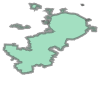

In [ ]:
gdf_moscow.iloc[0,0]

#### amenities - скачивание (не запускать без надобности)

In [ ]:
# education

amenities_education = ['college','dancing_school','driving_school','first_aid_school','kindergarten','language_school','library','surf_school','toy_library','research_institute','training','music_school','school','traffic_park','university']
OSM_edu, no_data_edu = OSMdata(cities, 'amenity', amenities_education, 'education')

<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `

In [ ]:
# transport

amenities_transport = ['bicycle_parking','bicycle_repair_station','bicycle_rental','bicycle_wash','boat_rental','boat_sharing','bus_station','car_rental','car_sharing','car_wash','compressed_air','vehicle_inspection','charging_station','driver_training','ferry_terminal','fuel','grit_bin','motorcycle_parking','parking','parking_entrance','parking_space','taxi','weighbridge',]
OSM_transport, no_data_transport = OSMdata(cities, 'amenity', amenities_transport, 'transport')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# finances

amenities_finances = ['atm','payment_terminal','bank','bureau_de_change','money_transfer','payment_centre']
OSM_finances, no_data_finances = OSMdata(cities, 'amenity', amenities_finances, 'finances')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# health

amenities_health = ['baby_hatch','clinic','dentist','doctors','hospital','nursing_home','pharmacy','social_facility','veterinary']
OSM_health, no_data_health = OSMdata(cities, 'amenity', amenities_health, 'health')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# fun, art, culture

amenities_art_fun = ['arts_centre','brothel','casino','cinema','community_centre','conference_centre','events_venue','exhibition_centre','fountain','love_hotel','music_venue','nightclub','planetarium','public_bookcase','social_centre','stage','stripclub','studio','swingerclub','theatre']
OSM_art_fun, no_data_art_fun = OSMdata(cities, 'amenity', amenities_art_fun, 'art_fun')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# social services

amenities_soc_service = ['courthouse','fire_station','police','post_box','post_depot','post_office','prison','ranger_station','townhall']
OSM_soc_service, no_data_soc_service = OSMdata(cities, 'amenity', amenities_soc_service, 'soc_service')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# improvement

amenities_improvement = ['bbq','bench','dog_toilet','dressing_room','drinking_water','give_box','mailroom','parcel_locker','shelter','shower','telephone','toilets','water_point','watering_place']
OSM_improvement, no_data_improvement = OSMdata(cities, 'amenity', amenities_improvement, 'improvement')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# Other amenitites

amenities_other = ['animal_boarding','animal_breeding','animal_shelter','animal_training','baking_oven','clock','crematorium','dive_centre','funeral_hall','grave_yard','hunting_stand','internet_cafe','kitchen','kneipp_water_cure','lounger','marketplace','monastery','mortuary','photo_booth','place_of_mourning','place_of_worship','public_bath','public_building','refugee_site','vending_machine']
OSM_amenities_other, no_data_amenities_other = OSMdata(cities, 'amenity', amenities_other, 'amenities_other')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

#### office

In [ ]:
# offices

offices = ['accountant','administrative','advertising_agency','architect','association','chamber','charity','company','construction_company','consulting','courier','coworking','diplomatic','educational_institution','employment_agency','energy_supplier','engineer','estate_agent','financial','financial_advisor','forestry','foundation','geodesist','government','graphic_design','guide','harbour_master','insurance','it','lawyer','logistics','moving_company','newspaper','ngo','notary','politician','political_party','property_management','publisher','quango','religion','research','security','surveyor','tax_advisor','telecommunication','therapist','travel_agent','tutoring','union','visa','water_utility','yes']
OSM_offices, no_data_offices = OSMdata(cities, 'office', offices, 'office')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

#### highways

In [ ]:
# highway roads

highway_roads = ['motorway','trunk','primary','secondary','tertiary','unclassified','residential']
OSM_roads, no_data_roads = OSMdata(cities, 'highway', highway_roads, 'roads')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# highway

highway_special_roads = ['living_street','service','pedestrian','track','bus_guideway','escape','raceway','road','busway']
OSM_special_roads, no_data_special_roads = OSMdata(cities, 'highway', highway_special_roads, 'special_roads')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

#### building

In [ ]:
#living building

building_living = ['apartments','barracks','bungalow','cabin','detached','dormitory','farm','ger','hotel','house','houseboat','residential','semidetached_house','static_caravan','stilt_house','terrace','tree_house','trullo']
OSM_building_living, no_data_building_living = OSMdata(cities, 'building', building_living, 'living')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# commercial building

building_commercial = ['commercial','industrial','kiosk','office','retail','supermarket','warehouse']
OSM_building_commercial, no_data_building_commercial = OSMdata(cities, 'building', building_commercial, 'commercial')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
# building religious

building_religious = ['religious','cathedral','chapel','church','kingdom_hall','monastery','mosque','presbytery','shrine','synagogue','temple']
OSM_building_religious, no_data_building_religious = OSMdata(cities, 'building', building_religious, 'religious')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
#building civic

building_civic = ['bakehouse','bridge','civic','college','fire_station','government','gatehouse','hospital','kindergarten','museum','public','school','toilets','train_station','transportation','university']
OSM_building_civic, no_data_building_civic = OSMdata(cities, 'building', building_civic, 'civic')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

In [ ]:
#building sport

building_sport = ['grandstand','pavilion','riding_hall','sports_hall','sports_centre','stadium']
OSM_building_sport, no_data_building_sport = OSMdata(cities, 'building', building_sport, 'sport')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  data_temp = ox.geometries_from_polygon(cities, {key: object_}).reset_index()
<ipython-input-63-ab274f707138>:17: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use

#### Соединение файлов в один файл

In [ ]:
OSM_soc_service.to_excel('OSM_soc_service.xlsx', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
#OSM_edu = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_edu.xlsx')
#OSM_transport = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_transport.xlsx')
#OSM_finances = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_finances.xlsx')
#OSM_health = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_health.xlsx')
#OSM_art_fun = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_art_fun.xlsx')
#OSM_soc_service = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_soc_service.xlsx')
#OSM_improvement = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_improvement.xlsx')
#OSM_amenities_other = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_amenities_other.xlsx')


#OSM_offices = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_offices.xlsx')


#OSM_roads = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_roads.xlsx')
#OSM_special_roads = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_special_roads.xlsx')
#OSM_building_living = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_building_living.xlsx')
#OSM_building_commercial = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_building_commercial.xlsx')
#OSM_building_religious = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_building_religious.xlsx')
#OSM_building_civic = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_building_civic.xlsx')
#OSM_building_sport = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/Выгрузки по отдельности/OSM_building_sport.xlsx')


In [ ]:
amenitis_osm = pd.concat([OSM_edu, OSM_transport])
amenitis_osm = pd.concat([amenitis_osm, OSM_finances])
amenitis_osm = pd.concat([amenitis_osm, OSM_health])
amenitis_osm = pd.concat([amenitis_osm, OSM_art_fun])
amenitis_osm = pd.concat([amenitis_osm, OSM_soc_service])
amenitis_osm = pd.concat([amenitis_osm, OSM_improvement])
amenitis_osm = pd.concat([amenitis_osm, OSM_amenities_other])

amenitis_osm = amenitis_osm.rename(columns = {'amenity':'key'})

In [ ]:
OSM_offices = OSM_offices.rename(columns = {'office':'key'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
roads_OSM = pd.concat([OSM_roads, OSM_special_roads])
roads_OSM = roads_OSM.rename(columns = {'highway':'key'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
buildings_OSM = pd.concat([OSM_building_living, OSM_building_commercial])
buildings_OSM = pd.concat([buildings_OSM, OSM_building_religious])
buildings_OSM = pd.concat([buildings_OSM, OSM_building_civic])
buildings_OSM = pd.concat([buildings_OSM, OSM_building_sport])
buildings_OSM = buildings_OSM.rename(columns = {'building': 'key'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
OSM_data = pd.concat([amenitis_osm, OSM_offices])
OSM_data = pd.concat([OSM_data, roads_OSM])
OSM_data = pd.concat([OSM_data, buildings_OSM])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
OSM_data.to_excel('OSM_data.xlsx', index=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
OSM_data = pd.read_excel('/content/drive/My Drive/Магистратура/Курсовая/Выгрузки из OSM/OSM_data.xlsx')